In [200]:
import os
import pickle
import cv2
import numpy as np
import math
import time
import sys 
import heapq

%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets.widgets as widgets
from IPython.display import display

import shapely.geometry
import shapely.ops

### Dijkstra code - for computing shortest path

https://benalexkeen.com/implementing-djikstras-shortest-path-algorithm-with-python/

In [210]:
from collections import defaultdict

class Graph():
    def __init__(self):
        """
        self.edges is a dict of all possible next nodes
        e.g. {'X': ['A', 'B', 'C', 'E'], ...}
        self.weights has all the weights between two nodes,
        with the two nodes as a tuple as the key
        e.g. {('X', 'A'): 7, ('X', 'B'): 2, ...}
        """
        self.edges = defaultdict(list)
        self.weights = {}
    
    def add_edge(self, from_node, to_node, weight):
        # Note: assumes edges are bi-directional
        self.edges[from_node].append(to_node)
        self.edges[to_node].append(from_node)
        self.weights[(from_node, to_node)] = weight
        self.weights[(to_node, from_node)] = weight

def dijsktra(graph, initial, end):
    # shortest paths is a dict of nodes
    # whose value is a tuple of (previous node, weight)
    shortest_paths = {initial: (None, 0)}
    current_node = initial
    visited = set()
    
    while current_node != end:
        visited.add(current_node)
        destinations = graph.edges[current_node]
        weight_to_current_node = shortest_paths[current_node][1]

        for next_node in destinations:
            weight = graph.weights[(current_node, next_node)] + weight_to_current_node
            if next_node not in shortest_paths:
                shortest_paths[next_node] = (current_node, weight)
            else:
                current_shortest_weight = shortest_paths[next_node][1]
                if current_shortest_weight > weight:
                    shortest_paths[next_node] = (current_node, weight)
        
        next_destinations = {node: shortest_paths[node] for node in shortest_paths if node not in visited}
        if not next_destinations:
            return "Route Not Possible"
        # next node is the destination with the lowest weight
        current_node = min(next_destinations, key=lambda k: next_destinations[k][1])
    
    # Work back through destinations in shortest path
    path = []
    while current_node is not None:
        path.append(current_node)
        next_node = shortest_paths[current_node][0]
        current_node = next_node
    # Reverse path
    path = path[::-1]
    return path

In [212]:
graph = Graph()

edges = [
    ('X', 'A', 7),
    ('X', 'B', 2),
    ('X', 'C', 3),
    ('X', 'E', 4),
    ('A', 'B', 3),
    ('A', 'D', 4),
    ('B', 'D', 4),
    ('B', 'H', 5),
    ('C', 'L', 2),
    ('D', 'F', 1),
    ('F', 'H', 3),
    ('G', 'H', 2),
    ('G', 'Y', 2),
    ('I', 'J', 6),
    ('I', 'K', 4),
    ('I', 'L', 4),
    ('J', 'L', 1),
    ('K', 'Y', 5),
]

for edge in edges:
    graph.add_edge(*edge)
    
dijsktra(graph, 'X', 'Y')

['X', 'B', 'H', 'G', 'Y']

In [347]:
def normalize_angle(angle):
    """ Normalize angle to between +pi and -pi """
    """ Important for EKF Correction Step !!!  """
    return (angle+math.pi)%(2*math.pi)-math.pi

def control2robot(wheel_radius, axle_length):
    """ transform wheel speeds to robot motion in world frame """
    l = axle_length
    r = wheel_radius

    return np.array([[r/2, r/2],
                  [r/l, -r/l]])

def robot_pose_delta(v,w,theta,dt):
    """ Calculate change in robot pose in world frame """
    
    """ An alternate way - can avoid divide by zero error if w is zero
    x_delta = v*dt*math.cos(theta)
    y_delta = v*dt*math.sin(theta)
    """
    arc_radius = v/w   # arc radius
    
    x_delta = arc_radius*(math.sin(theta+w*dt)-math.sin(theta))
    y_delta = arc_radius*(math.cos(theta)-math.cos(theta+w*dt))
    theta_delta = w*dt
    
    return x_delta, y_delta, theta_delta

## Landmarks and Central Barrier

In [248]:
# Landmarks
landmarks = [
    {
    "label": 19,
    "obj_name": 'horse',
    "width": 0.394,
    "observed": False,
    "actual_x": 1.50,
    "actual_y": 1.50,
    "Mu": [],
    "blocked": [[1.3,1.56],[1.7,1.44]],    
    "barrier": np.array([[1.3,1.44],
                    [1.3,1.56],
                    [1.5,1.56],
                    [1.7,1.56],
                    [1.7,1.44],
                    [1.5,1.44]
                   ])
    },
    {
    "label": 44,
    "obj_name": 'bottle',
    "width": 0.10,
    "observed": False,
    "actual_x": 0.75,
    "actual_y": 1.50,
    "Mu": [],
    "blocked": [[0.7,1.55],[0.8,1.45]],    
    "barrier": np.array([[0.8,1.55],
                    [0.8,1.45],
                    [0.7,1.45],
                    [0.7,1.55]
                   ])
    },
    {
    "label": 63,
    "obj_name": 'couch',
    "width": 1.68,
    "observed": False,
    "actual_x": -0.50,
    "actual_y": 1.21,
    "Mu": [],
    "blocked": [[-1.45,2.18],[-0.25,0.5]],    
    "barrier": np.array([[-1.45,2.18],
                    [-0.25,2.18],
                    [-0.25,1.8],                         
                    [-0.25,1.4], 
                    [-0.25,1.0],
                    [-0.25,0.5],
                    [-1.45,0.5],
                    [-1.45,1.34]
                   ])
    },
    {
    "label": 72,
    "obj_name": 'TV',
    "width": 1.00,
    "observed": False,
    "actual_x": 2.0,
    "actual_y": 0.9,
    "Mu": [],
    "blocked": [[1.9,1.5],[2.5,0.25]],    
    "barrier": np.array([[1.9,1.5],
                    [2.5,1.5],
                    [2.5,0.9],
                    [2.5,0.25],
                    [1.9,0.25],
                    [1.9,0.9]
                   ])
    },
    {
    "label": 64,
    "obj_name": 'potted plant',
    "width": 0.55,
    "observed": False,
    "actual_x": 0.5,
    "actual_y": -0.10,
    "Mu": [],
    "blocked": [[0.2,0.1],[0.8,-0.3]],    
    "barrier": np.array([[0.2,0.1],
                    [0.8,0.1],
                    [0.8,-0.3],
                    [0.2,-0.3]
                   ])
    }
]

# Central barrier - 0.5m x 0.5m
barrier = np.array([[0.5,0.5],
                    [0.5,0.75],
                    [0.5,1.0],
                    [0.75,1.0],
                    [1.0,1.0],
                    [1.0,0.75],
                    [1.0,0.5],
                    [0.75,0.5]
                   ])

blocked = [[0.5,1.0],[1.0,0.5]]

### Plot Map

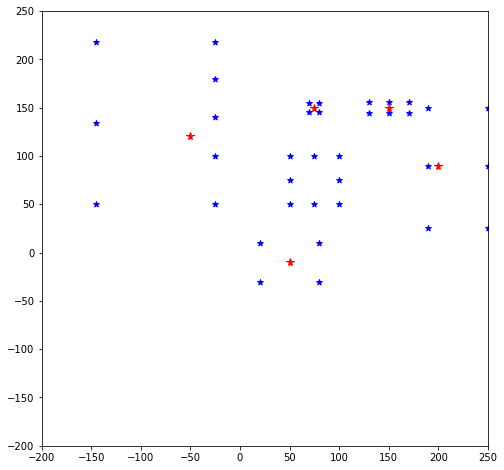

In [314]:
""" Update robot position on map """
plt.figure(figsize=(8,8))
plt.xlim([-200,250])
plt.ylim([-200,250])

    
""" Display landmark as green cross, uncorrected landmark as lime cross """
for i, landmark in enumerate(landmarks):
    # Mark landmark's actual locations
    landmark_x_actual = landmark["actual_x"]*100
    landmark_y_actual = landmark["actual_y"]*100
    plt.plot(landmark_x_actual, landmark_y_actual, marker='*', markersize=8, color='red')
    
    if landmark["blocked"] is not None:
        plt.scatter(landmark["barrier"][:,0]*100, landmark["barrier"][:,1]*100, marker='*', color='blue') 
    
""" Display central barrier """
plt.scatter(barrier[:,0]*100, barrier[:,1]*100, marker='*', color='blue')     

plt.show()
plt.close()

## Voronoi Diagram --> Legal Paths

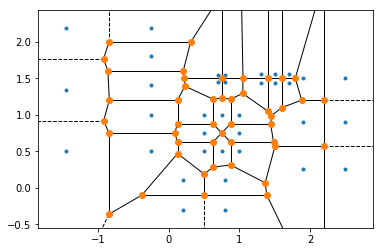

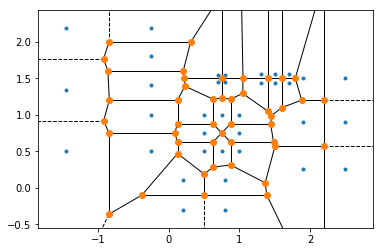

In [315]:
from scipy.spatial import Voronoi, voronoi_plot_2d

num_pt = 0
for landmark in landmarks:
        landmark_barrier = landmark["barrier"]
        num, _ = landmark_barrier.shape
        num_pt += num
        
num, _ = barrier.shape
num_pt += num
points = np.zeros((num_pt,2))

# create landmark points
j = 0
for landmark in landmarks:
        landmark_barrier = landmark["barrier"]
        num, _ = landmark_barrier.shape
        for i in range(num):
            points[j,0] = landmark_barrier[i,0]
            points[j,1] = landmark_barrier[i,1]
            j += 1
    
# create barrier points
num, _ = barrier.shape
for i in range(num):
    points[j,0] = barrier[i,0]
    points[j,1] = barrier[i,1]    
    j += 1
    
vor = Voronoi(points)
voronoi_plot_2d(vor)

3 4 [0.30789474 1.99      ] [0.20526316 1.6       ] 0.4032781186690274
7 16 [0.22105263 1.5       ] [0.22679641 1.39086826] 0.10928278398543254
16 17 [0.22679641 1.39086826] [0.625      1.21388889] 0.4357611735325622
17 18 [0.625      1.21388889] [0.75       1.22777778] 0.12576923802968634
3 8 [0.30789474 1.99      ] [0.75       2.65666667] 0.7999384402292186
4 7 [0.20526316 1.6       ] [0.22105263 1.5       ] 0.10123886348248064
20 23 [0.875  0.3125] [0.625   0.28125] 0.25194555463432966
20 22 [0.875  0.3125] [1.36463415 0.06768293] 0.547427617662296
21 22 [ 1.3875 -0.1   ] [1.36463415 0.06768293] 0.16923478133517178
23 24 [0.625   0.28125] [0.5    0.1875] 0.15625
10 11 [1.48333333 0.625     ] [1.50555556 0.575     ] 0.054715876676645035
11 22 [1.50555556 0.575     ] [1.36463415 0.06768293] 0.5265258363132839
1 21 [ 2.2   -1.725] [ 1.3875 -0.1   ] 1.816805231718579
13 14 [-0.38055556 -0.1       ] [0.125   0.46875] 0.7609618796320131
14 24 [0.125   0.46875] [0.5    0.1875] 0.46875
0 13

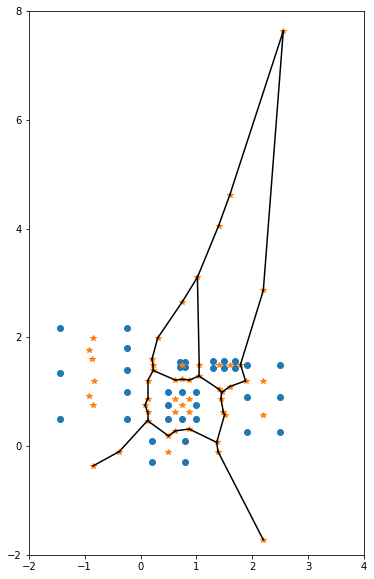

In [316]:
def in_blocked_area(blocked, point):
    """ Check if a point falls within a blocked region """
    x,y = point
    ULeft_x, ULeft_y = blocked[0]
    LRight_x, LRight_y = blocked[1]
    
    if (ULeft_x<=x<=LRight_x) and (ULeft_y>=y>=LRight_y):
        return True
    else:
        return False
    
def valid_point(blocked_areas ,point):
    """ A point is valid if it does not wihin a list of blocked regions """
    for area in blocked_areas:
        if in_blocked_area(area, point):
            return False

    return True

blocked_areas = []
blocked_areas.append(blocked)
for landmark in landmarks:
        blocked_areas.append(landmark["blocked"])
        
# Graph for shortest distance computation
graph = Graph()
edges = []

plt.figure(figsize=(6,10))    
plt.plot(points[:, 0], points[:, 1], 'o')
plt.plot(vor.vertices[:, 0], vor.vertices[:, 1], '*')
plt.xlim(-2, 4); plt.ylim(-2, 8)

i = 0
for simplex in vor.ridge_vertices:
    simplex = np.asarray(simplex)
    x = vor.vertices[simplex, 0]  
    y = vor.vertices[simplex, 1]
    start = vor.vertices[simplex[0]] 
    end = vor.vertices[simplex[1]]
    
    if np.all(simplex >= 0) and (valid_point(blocked_areas,start) and valid_point(blocked_areas,end)):
        
        dist = np.linalg.norm(start-end)
        edges.append((str(simplex[0]),str(simplex[1]),dist))
        print(str(simplex[0]),str(simplex[1]), start, end, dist)
        plt.plot(x,y,'k-', color="black")

    # print(simplex)
    # print ("start {}, end{}".format(start,end))
    # print ("{},{}".format(in_blocked_area(blocked, start),in_blocked_area(blocked, end)))
        
    i += 1


In [317]:
edges 

[('3', '4', 0.4032781186690274),
 ('7', '16', 0.10928278398543254),
 ('16', '17', 0.4357611735325622),
 ('17', '18', 0.12576923802968634),
 ('3', '8', 0.7999384402292186),
 ('4', '7', 0.10123886348248064),
 ('20', '23', 0.25194555463432966),
 ('20', '22', 0.547427617662296),
 ('21', '22', 0.16923478133517178),
 ('23', '24', 0.15625),
 ('10', '11', 0.054715876676645035),
 ('11', '22', 0.5265258363132839),
 ('1', '21', 1.816805231718579),
 ('13', '14', 0.7609618796320131),
 ('14', '24', 0.46875),
 ('0', '13', 0.5386159024072751),
 ('16', '26', 0.21631736526946105),
 ('8', '9', 0.5228420199044619),
 ('9', '30', 1.605320967906418),
 ('31', '32', 0.11363222456601439),
 ('32', '33', 0.08206623888570773),
 ('33', '35', 0.4273571595969724),
 ('35', '36', 0.18811956344387337),
 ('18', '36', 0.12576923802968634),
 ('30', '35', 0.20975045769007633),
 ('9', '37', 1.0258738957591227),
 ('40', '41', 0.13176156917368245),
 ('41', '42', 0.13176156917368245),
 ('14', '40', 0.15625),
 ('26', '42', 0.324

## Shortest Path Search

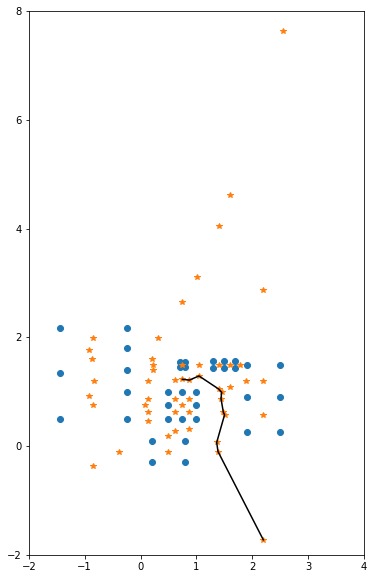

In [318]:
for edge in edges:
    graph.add_edge(*edge)
    
shortest = dijsktra(graph, '1', '18')

plt.figure(figsize=(6,10))    
plt.plot(points[:, 0], points[:, 1], 'o')
plt.plot(vor.vertices[:, 0], vor.vertices[:, 1], '*')
plt.xlim(-2, 4); plt.ylim(-2, 8)

x = []
y = []

for pt in shortest:
    idx = int(pt)
    x.append(vor.vertices[idx, 0])  
    y.append(vor.vertices[idx, 1])
    # print (pt,x,y)
    
plt.plot(x,y,'k-', color="black")

In [319]:
shortest

['1', '21', '22', '11', '10', '31', '32', '33', '35', '36', '18']

## Implement Pursuit

In [546]:
robot_params = {
    # pose
    "start_x": 1.0,
    "start_y": 0.3,
    "start_theta": 0,
    # physical dimensions
    "wheel_radius": 0.0325,
    "axle_length": 0.12,
    "camera_offset": 0.06, # camera is +6cm from center of wheel axle
    "focal_length": 0.00315, # camera focal lenght in meter
    # stepwise motor control
    "motor_on_time": 0.1,  
    "motor_off_time": 0.2,
    # wheel velocity control
    "min_ang_velocity": 6.5, # Equivalent to motor speed setting of 0.3
}

control_params = {
    "num_iter": 301,
    "interval": 10,
    "debug": True,
    "motion": False,
    "speed_lower": 0.14,  # This ensures motor settings > ~0.3
    "speed_upper": 5.0  # This ensures motor settings > ~0.5
}

pursuit_params = {
    "K_v": 0.5,
    "K_i": 0,
    "K_h": 0.5,
    "lag": 0.02
}

trajec_params = {
    "points": [],   # used for storing evenly spaced points in trajectory
    "current": 0,   # point to the current pursuit point
}

# Mapping between set_motor "speed" and measured wheel angular velocity "omega"
# for 0.1 second motor running time
wheel_calibration = {
    "speed": [0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    "omega": [0.0, 3.85, 9.23, 15.0, 25.8, 29.2, 35.4]
}

In [547]:
def distance(pt1, pt2):
    """ Distance between 2 points """
    pt1 = np.array(pt1)
    pt2 = np.array(pt2)
    return np.linalg.norm(pt1-pt2)
    
def generate_points(start, end, interval, debug=False):
    """ Generate a sequence of equally distance points for a path """
    start_x, start_y = start
    end_x, end_y = end
    theta = math.atan2((end_y-start_y),(end_x-start_x))
       
    if debug:
        print("From {} to {}".format(np.around(np.array(start),3), np.around(np.array(end),3)))
        print("theta: {:.1f}".format(theta))
    
    points = []
    current_pt = start
    next_pt = start
    
    # Generate a sequence of points from start to end
    while distance(start,next_pt) < distance(start,end):
        points.append(current_pt)
        next_pt = (current_pt[0] + interval*math.cos(theta), current_pt[1]+interval*math.sin(theta))
        current_pt = next_pt
        
    return points

def generate_trajectory(path, vor, interval, debug=False):
    """ Convert path into points for robot to follow """
    
    points = []
    # for each path segment
    for i in range(len(path)-1):
        # generate points for the segment
        start = [vor.vertices[int(path[i]), 0],vor.vertices[int(path[i]), 1]]
        end = [vor.vertices[int(path[i+1]), 0],vor.vertices[int(path[i+1]), 1]]
        if debug:
            print(path[i], path[i+1])
        points.extend(generate_points(start,end,interval)) 
        
    return points

def closest_point(traj, robot_pose):
    """ Pick the next point in the trajectory to pursue """
    robot_x = robot_pose[0]
    robot_y = robot_pose[1]
    robot_theta = robot_pose[2]
    
    current = traj["current"]
    points = traj["points"][current:]
    
    nearest = None
    # Go through all pts in trajectory and pick the pt nearest to robot
    for i, pt in enumerate(points):
        if nearest is None:
            nearest = pt
        else:
            if distance(pt,[robot_x,robot_y])<distance(nearest,[robot_x,robot_y]):
                nearest = pt
                current = traj["current"]+i
                
    return current, nearest


def animate_robot(robot_pose, landmarks, vor, display_param, path=None, pursuit_pt=None):
    """ Update map to display landmarks, robot, trajectory and pursuit point """
    
    # Load display parameters
    figsize = display_param["figsize"]
    plt.figure(figsize=figsize) 
    plt.xlim(display_param["xlim"]); plt.ylim(display_param["ylim"])
    
    # Plot landmarks and voronoi vertices
    plt.plot(landmarks[:, 0], landmarks[:, 1], 'o')
    plt.plot(vor.vertices[:, 0], vor.vertices[:, 1], '*')
    
    # Plot trajectory
    if path is not None:
        path = np.array(path)
        plt.plot(path[:,0],path[:,1], 'x')
    
    # Plot robot pose (robot = line + triangle)
    robot_x_actual = robot_pose[0]
    robot_y_actual = robot_pose[1]
    robot_theta_actual = robot_pose[2]*180/math.pi - 90 # Adjust orientation to match matplotlib    
    
    plt.plot(robot_x_actual, robot_y_actual, marker=(2, 0, robot_theta_actual), \
             c='r',markersize=15, linestyle='None')
    plt.plot(robot_x_actual, robot_y_actual, marker=(3, 0, robot_theta_actual), \
             c='r',markersize=10, linestyle='None')

    # Plot pursuit pt
    if pursuit_pt is not None:
        plt.plot(pursuit_pt[0],pursuit_pt[1], 'x', c='r')

    plt.show()
    plt.close()
    
    return

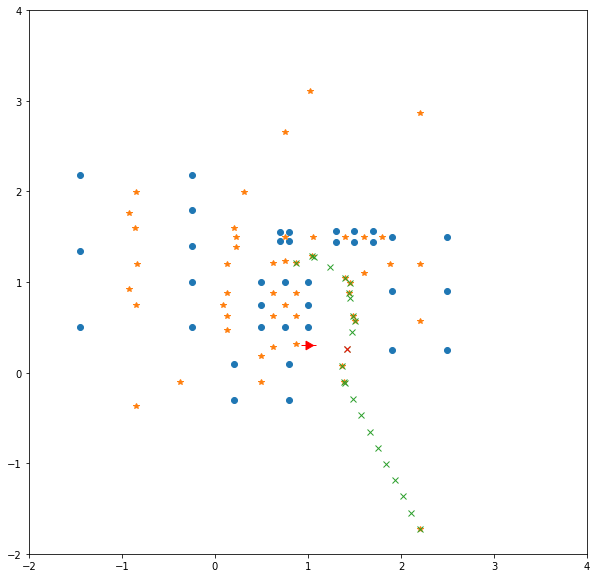

In [548]:
robot_pose = [robot_params["start_x"],robot_params["start_y"],robot_params["start_theta"]]

# Initialize trajec_params
trajec_params["points"] = generate_trajectory(shortest, vor, 0.20, debug=False)
trajec_params["current"] = 0

# pursuit point is set at the pt in trajectory closest to the robot
trajec_params["current"], pursuit_pt = closest_point(trajec_params,robot_pose)

display_param = {
    "figsize": (10,10),
    "xlim": [-2,4],
    "ylim": [-2,4]
    }

# Update map
animate_robot(robot_pose, points, vor, display_param, path=trajec_params["points"], pursuit_pt=pursuit_pt)

1 21
21 22
22 11
11 10
10 31
31 32
32 33
33 35
35 36
36 18
[[ 0.2061766 ]
 [-0.28363503]]


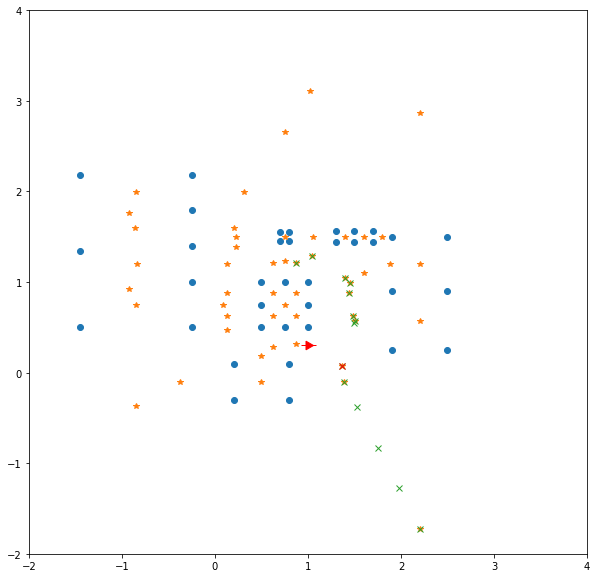

Step:  1
theta:-0.5672700503534143
e:0.41235319261546194 e_theta:-0.5672700503534145
(v,omega): [[ 0.2061766 ]
 [-0.28363503]]
(x,y,theta) before: 1.0, 0.3, 0
Clamped wheel Velocities: [[5.82026138]
 [6.86752916]] (0.35608790266990875, 0.3366219587058225)
(x,y,theta) after: 1.0206148952977305, 0.2997076250813816, -0.028363502517670638
[[ 0.19747572]
 [-0.28250503]]
[[ 0.18913001]
 [-0.28135812]]
[[ 0.18112534]
 [-0.28019346]]
[[ 0.17344816]
 [-0.27901018]]
[[ 0.16608544]
 [-0.27780739]]
[[ 0.15902463]
 [-0.27658417]]
[[ 0.1522537]
 [-0.2753396]]
[[ 0.14576106]
 [-0.27407272]]
[[ 0.13953558]
 [-0.27278256]]
Robot speed boosted [[ 0.14      ]
 [-0.27278256]]
[[ 0.13354686]
 [-0.27151086]]
Robot speed boosted [[ 0.14      ]
 [-0.27151086]]


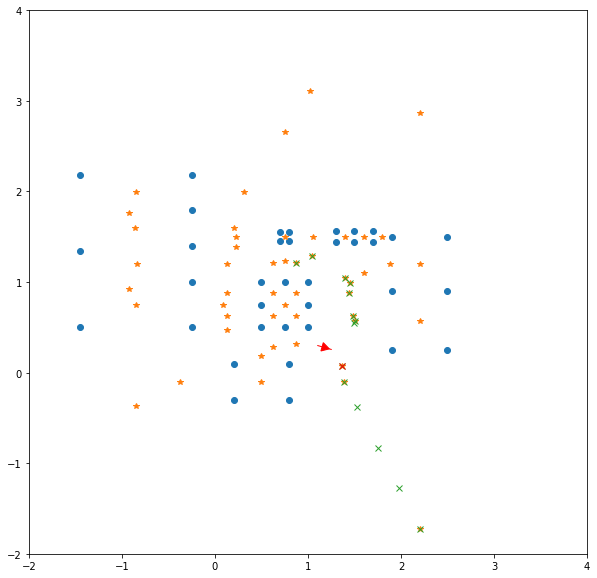

Step:  11
theta:-0.821350546324186
e:0.26709371443523516 e_theta:-0.5430217217882256
(v,omega): [[ 0.14      ]
 [-0.27151086]]
(x,y,theta) before: 1.1690563940415106, 0.2778546272875335, -0.2783288245359605
Clamped wheel Velocities: [[3.80644149]
 [4.80894313]] (0.317824221706404, 0.2994343050335081)
(x,y,theta) after: 1.182463748335228, 0.27382587928004604, -0.30547991062537166
[[ 0.12755087]
 [-0.27078754]]
Robot speed boosted [[ 0.14      ]
 [-0.27078754]]
[[ 0.12155175]
 [-0.27065421]]
Robot speed boosted [[ 0.14      ]
 [-0.27065421]]
[[ 0.11555393]
 [-0.27116187]]
Robot speed boosted [[ 0.14      ]
 [-0.27116187]]
[[ 0.10956226]
 [-0.27237299]]
Robot speed boosted [[ 0.14      ]
 [-0.27237299]]
[[ 0.10358214]
 [-0.27436421]]
Robot speed boosted [[ 0.14      ]
 [-0.27436421]]
[[ 0.09761967]
 [-0.27722983]]
Robot speed boosted [[ 0.14      ]
 [-0.27722983]]
[[ 0.09168189]
 [-0.28108624]]
Robot speed boosted [[ 0.14      ]
 [-0.28108624]]
[[ 0.08577702]
 [-0.28607792]]
Robot speed b

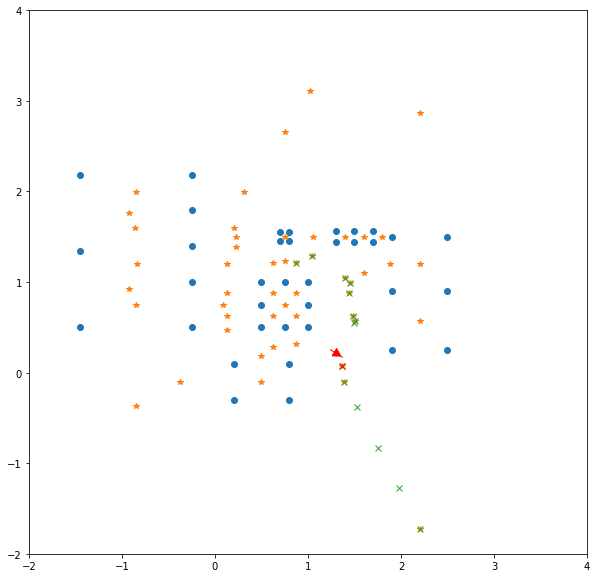

Step:  21
theta:-1.155559643620555
e:0.1482144420137218 e_theta:-0.6004677450607634
(v,omega): [[ 0.14      ]
 [-0.30023387]]
(x,y,theta) before: 1.2967753450667558, 0.22160265133378906, -0.5550918985597917
Clamped wheel Velocities: [[3.75341439]
 [4.86197023]] (0.31880985550576124, 0.29874564141785326)
(x,y,theta) after: 1.308560733379456, 0.21404686548235047, -0.5851152858128298
[[ 0.06836873]
 [-0.30990986]]
Robot speed boosted [[ 0.14      ]
 [-0.30990986]]
[[ 0.0627176 ]
 [-0.32177548]]
Robot speed boosted [[ 0.14      ]
 [-0.32177548]]
[[ 0.05717702]
 [-0.33629267]]
Robot speed boosted [[ 0.14      ]
 [-0.33629267]]
[[ 0.05177686]
 [-0.3540508 ]]
Robot speed boosted [[ 0.14     ]
 [-0.3540508]]
[[ 0.04655614]
 [-0.37579853]]
Robot speed boosted [[ 0.14      ]
 [-0.37579853]]
[[ 0.04156639]
 [-0.40247325]]
Robot speed boosted [[ 0.14      ]
 [-0.40247325]]
[[0.19401524]
 [1.02735672]]
[[0.19826603]
 [0.99713029]]
[[0.2020834 ]
 [0.96903064]]
[[0.2054628 ]
 [0.94284378]]


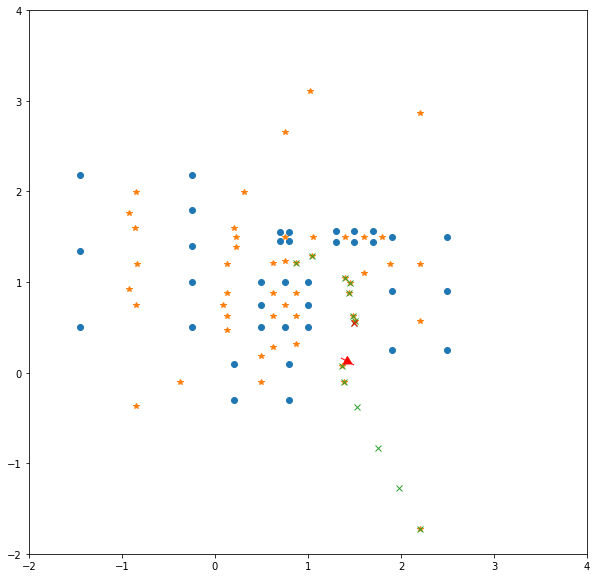

Step:  31
theta:1.3898939796206546
e:0.4109255926741459 e_theta:1.8856875587761
(v,omega): [[0.2054628 ]
 [0.94284378]]
(x,y,theta) before: 1.4209251224601926, 0.12554824248662566, -0.4957935791554455
Clamped wheel Velocities: [[8.06256686]
 [4.58129753]] (0.31359289080571473, 0.37830049934249843)
(x,y,theta) after: 1.439431139652198, 0.11663957812705186, -0.40150920121664024
[[0.20840431]
 [0.9183816 ]]
[[0.21091201]
 [0.89547841]]
[[0.21299322]
 [0.87398794]]
[[0.21465799]
 [0.85378082]]
[[0.21591859]
 [0.83474228]]
[[0.21678905]
 [0.81677033]]
[[0.21728476]
 [0.79977403]]
[[0.21742219]
 [0.78367216]]
[[0.21721856]
 [0.76839194]]
[[0.21669159]
 [0.75386805]]


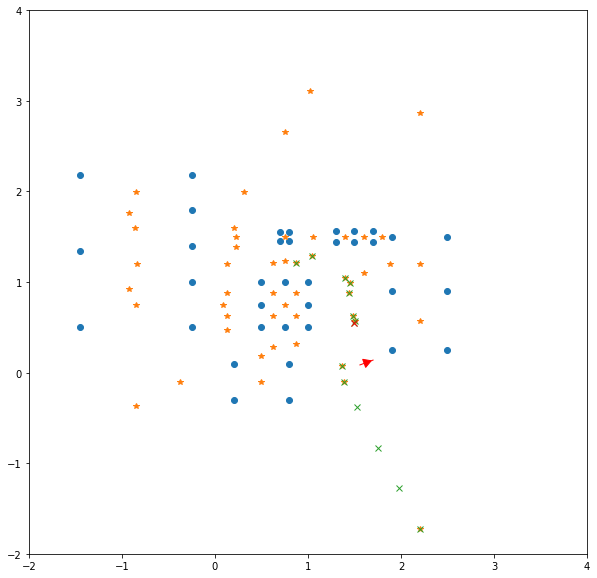

Step:  41
theta:1.8607248404410628
e:0.4333831888711741 e_theta:1.507736091082629
(v,omega): [[0.21669159]
 [0.75386805]]
(x,y,theta) before: 1.6280709522207344, 0.11498095084317106, 0.35298874935843433
Clamped wheel Velocities: [[8.05919007]
 [5.27567728]] (0.3264995777541381, 0.37823773358196655)
(x,y,theta) after: 1.6481025853815376, 0.12323103006316631, 0.428375553912566
[[0.21585934]
 [0.74004165]]
[[0.21473996]
 [0.7268597 ]]
[[0.21335159]
 [0.7142742 ]]
[[0.2117122 ]
 [0.70224163]]
[[0.2098395 ]
 [0.69072247]]
[[0.20775087]
 [0.67968073]]
[[0.20546322]
 [0.66908357]]
[[0.202993  ]
 [0.65890095]]
[[0.20035614]
 [0.64910536]]
[[0.19756798]
 [0.63967154]]


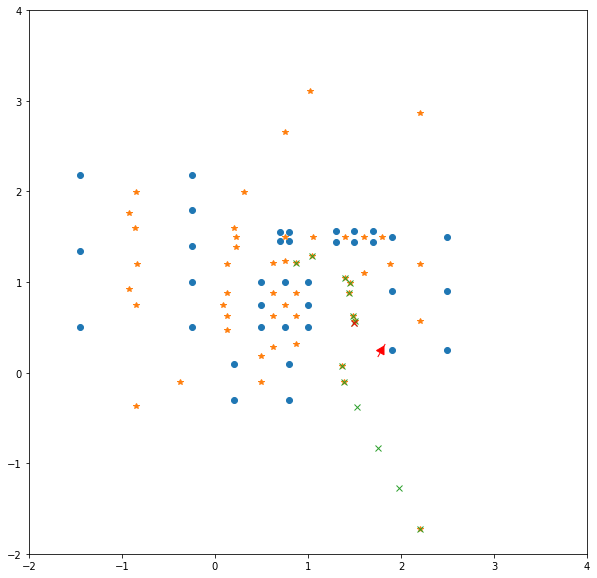

Step:  51
theta:2.3308096640489024
e:0.3951359530357554 e_theta:1.2793430846651237
(v,omega): [[0.19756798]
 [0.63967154]]
(x,y,theta) before: 1.784456152144739, 0.24854020795954676, 1.0514665793837787
Clamped wheel Velocities: [[7.25994674]
 [4.89808258]] (0.319481088920747, 0.3633819096699078)
(x,y,theta) after: 1.7937063408821636, 0.2659939176983825, 1.115433733617035
[[0.19464327]
 [0.63057625]]
[[0.19159615]
 [0.62179806]]
[[0.18844015]
 [0.61331719]]
[[0.18518814]
 [0.60511535]]
[[0.18185238]
 [0.59717557]]
[[0.17844449]
 [0.58948211]]
[[0.17497548]
 [0.58202032]]
[[0.17145573]
 [0.57477655]]
[[0.16789503]
 [0.56773807]]
[[0.16430259]
 [0.56089298]]


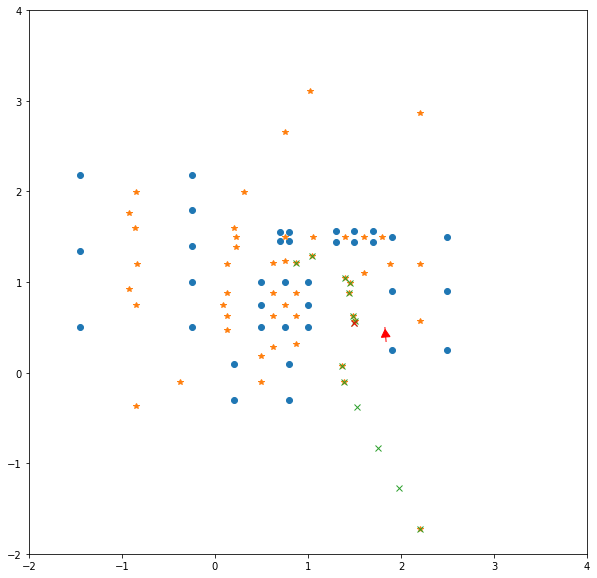

Step:  61
theta:2.7754196370652497
e:0.32860517300105097 e_theta:1.1217859562546062
(v,omega): [[0.16430259]
 [0.56089298]]
(x,y,theta) before: 1.8239502660250024, 0.4246256152455806, 1.6536336808106433
Clamped wheel Velocities: [[6.09095893]
 [4.01996947]] (0.30315928385066576, 0.3416535116889709)
(x,y,theta) after: 1.8221324152133238, 0.4409528333847103, 1.7097229786233739
[[0.16068703]
 [0.55423011]]
[[0.15705643]
 [0.54773902]]
[[0.15341834]
 [0.54140988]]
[[0.14977978]
 [0.53523343]]
[[0.14614728]
 [0.52920097]]
[[0.1425269 ]
 [0.52330427]]
[[0.13892422]
 [0.51753553]]
Robot speed boosted [[0.14      ]
 [0.51753553]]
[[0.13531764]
 [0.51204789]]
Robot speed boosted [[0.14      ]
 [0.51204789]]
[[0.13164933]
 [0.5072209 ]]
Robot speed boosted [[0.14     ]
 [0.5072209]]
[[0.12792757]
 [0.50306582]]
Robot speed boosted [[0.14      ]
 [0.50306582]]


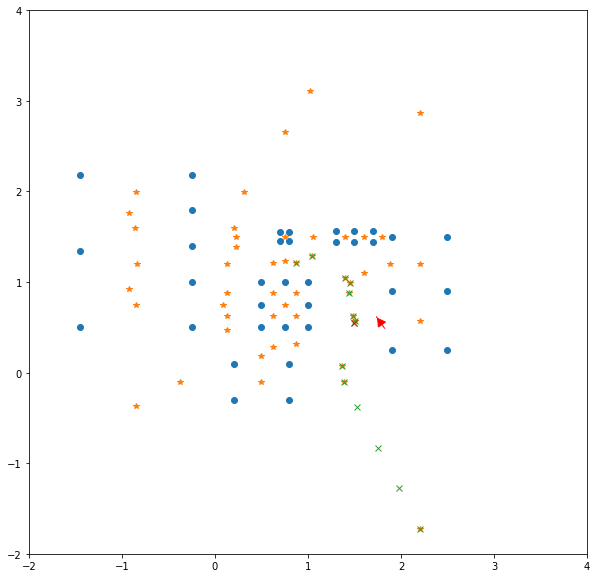

Step:  71
theta:-3.0905384861531897
e:0.25585513021325357 e_theta:1.0061316420843944
(v,omega): [[0.14      ]
 [0.50306582]]
(x,y,theta) before: 1.7739517744686686, 0.5635193182513661, 2.1865151789420025
Clamped wheel Velocities: [[5.23642921]
 [3.37895541]] (0.29388253775723033, 0.3257700596297013)
(x,y,theta) after: 1.7655821305049575, 0.574740179527946, 2.2368217610462224
[[0.12416066]
 [0.49959737]]
Robot speed boosted [[0.14      ]
 [0.49959737]]
[[0.120357  ]
 [0.49683391]]
Robot speed boosted [[0.14      ]
 [0.49683391]]
[[0.11652513]
 [0.4947978 ]]
Robot speed boosted [[0.14     ]
 [0.4947978]]
[[0.11267377]
 [0.49351562]]
Robot speed boosted [[0.14      ]
 [0.49351562]]
[[0.10881194]
 [0.49301854]]
Robot speed boosted [[0.14      ]
 [0.49301854]]
[[0.10494903]
 [0.49334263]]
Robot speed boosted [[0.14      ]
 [0.49334263]]
[[0.10109486]
 [0.49452911]]
Robot speed boosted [[0.14      ]
 [0.49452911]]
[[0.09725979]
 [0.49662469]]
Robot speed boosted [[0.14      ]
 [0.49662469]]


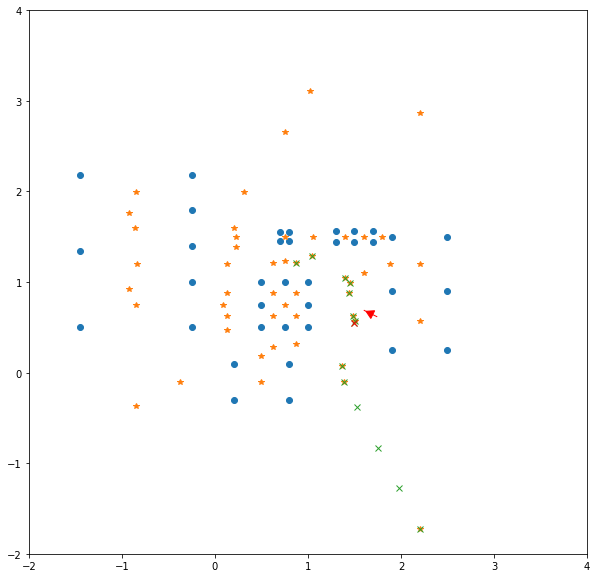

Step:  81
theta:-2.5926539085584723
e:0.1793836511924557 e_theta:1.0075155087253957
(v,omega): [[0.14      ]
 [0.50375775]]
(x,y,theta) before: 1.668546033424725, 0.6534767195891583, 2.6830158898957186
Clamped wheel Velocities: [[5.23770662]
 [3.37767799]] (0.2938659479473482, 0.32579380340964414)
(x,y,theta) after: 1.6558417075256302, 0.659355380792987, 2.7333916653319883
[[0.08598335]
 [0.50891629]]
Robot speed boosted [[0.14      ]
 [0.50891629]]
[[0.08234308]
 [0.51522511]]
Robot speed boosted [[0.14      ]
 [0.51522511]]
[[0.07878578]
 [0.52275567]]
Robot speed boosted [[0.14      ]
 [0.52275567]]
[[0.07532742]
 [0.5315811 ]]
Robot speed boosted [[0.14     ]
 [0.5315811]]
[[0.07198531]
 [0.54177334]]
Robot speed boosted [[0.14      ]
 [0.54177334]]
[[0.06877804]
 [0.55339899]]
Robot speed boosted [[0.14      ]
 [0.55339899]]
[[0.06572557]
 [0.56651372]]
Robot speed boosted [[0.14      ]
 [0.56651372]]
[[0.06284899]
 [0.58115484]]
Robot speed boosted [[0.14      ]
 [0.58115484]]
[[

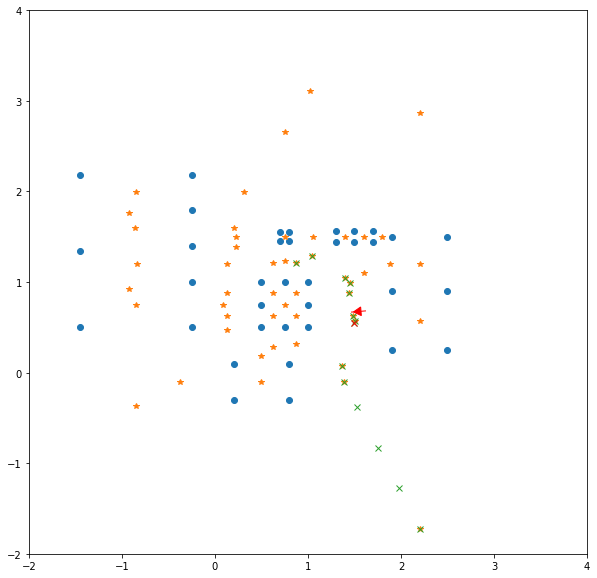

Step:  91
theta:-1.8278932701898072
e:0.11542442984787578 e_theta:1.2300352475352705
(v,omega): [[0.14      ]
 [0.61501762]]
(x,y,theta) before: 1.5328909880467354, 0.6804152116998121, 3.2252567894545088
Clamped wheel Velocities: [[5.44310946]
 [3.17227516]] (0.2911983786509261, 0.3296116999863077)
(x,y,theta) after: 1.518984715607061, 0.6788171458902285, 3.2867585518312725
[[0.05549692]
 [0.63413361]]
Robot speed boosted [[0.14      ]
 [0.63413361]]
[[0.05354585]
 [0.65454291]]
Robot speed boosted [[0.14      ]
 [0.65454291]]
[[0.05187833]
 [0.6760408 ]]
Robot speed boosted [[0.14     ]
 [0.6760408]]
[[0.05051044]
 [0.69835274]]
Robot speed boosted [[0.14      ]
 [0.69835274]]
[[0.0494538 ]
 [0.72113949]]
Robot speed boosted [[0.14      ]
 [0.72113949]]
[[0.04871453]
 [0.74401111]]
Robot speed boosted [[0.14      ]
 [0.74401111]]
[[0.04829248]
 [0.76654927]]
Robot speed boosted [[0.14      ]
 [0.76654927]]
[[0.04818093]
 [0.78833524]]
Robot speed boosted [[0.14      ]
 [0.78833524]]
[

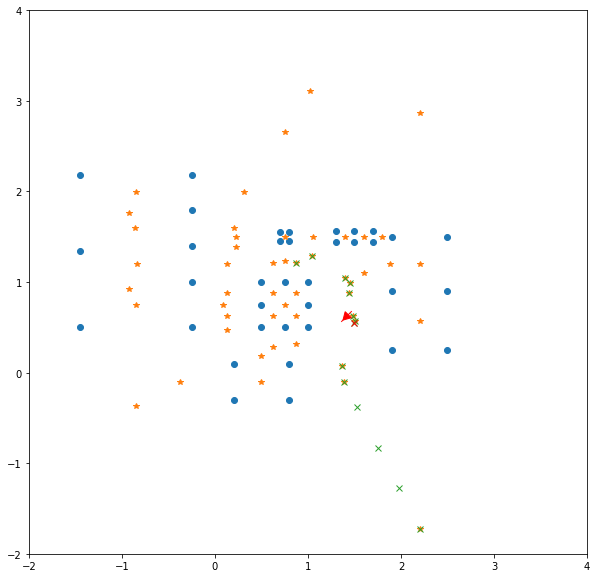

Step:  101
theta:-0.6909268629064477
e:0.09766295903549198 e_theta:1.6562914608881316
(v,omega): [[0.14      ]
 [0.82814573]]
(x,y,theta) before: 1.4077784480455364, 0.6244228079675344, 3.9359669833850073
Clamped wheel Velocities: [[5.83657673]
 [2.77880788]] (0.28608841405528745, 0.3369252180878724)
(x,y,theta) after: 1.398392757686793, 0.6140402830359819, 4.018781556429414
[[0.0495517 ]
 [0.84557269]]
Robot speed boosted [[0.14      ]
 [0.84557269]]
[[0.05050107]
 [0.86107943]]
Robot speed boosted [[0.14      ]
 [0.86107943]]
[[0.05165129]
 [0.87456671]]
Robot speed boosted [[0.14      ]
 [0.87456671]]
[[0.05297337]
 [0.88600898]]
Robot speed boosted [[0.14      ]
 [0.88600898]]
[[0.05443871]
 [0.89544217]]
Robot speed boosted [[0.14      ]
 [0.89544217]]
[[0.05601979]
 [0.9029496 ]]
Robot speed boosted [[0.14     ]
 [0.9029496]]
[[0.05769075]
 [0.90864815]]
Robot speed boosted [[0.14      ]
 [0.90864815]]
[[0.05942769]
 [0.91267593]]
Robot speed boosted [[0.14      ]
 [0.91267593]]


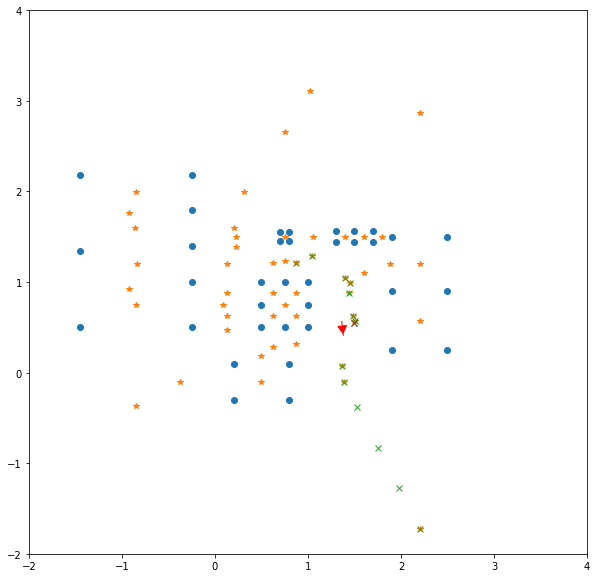

Step:  111
theta:0.36844818035461213
e:0.1260290086863029 e_theta:1.8326393421409204
(v,omega): [[0.14      ]
 [0.91631967]]
(x,y,theta) before: 1.3622274582274414, 0.4968468774245045, 4.818994145393278
Clamped wheel Velocities: [[5.99935939]
 [2.61602522]] (0.2839743535407685, 0.33995091808077127)
(x,y,theta) after: 1.3643523578010068, 0.48301402888576833, 4.910626112500324
[[0.06482725]
 [0.91623867]]
Robot speed boosted [[0.14      ]
 [0.91623867]]
[[0.06663154]
 [0.91508354]]
Robot speed boosted [[0.14      ]
 [0.91508354]]
[[0.06841375]
 [0.91299011]]
Robot speed boosted [[0.14      ]
 [0.91299011]]
[[0.07016202]
 [0.91008442]]
Robot speed boosted [[0.14      ]
 [0.91008442]]
[[0.07186605]
 [0.90648217]]
Robot speed boosted [[0.14      ]
 [0.90648217]]
[[0.07351702]
 [0.9022887 ]]
Robot speed boosted [[0.14     ]
 [0.9022887]]
[[0.07510744]
 [0.89759933]]
Robot speed boosted [[0.14      ]
 [0.89759933]]
[[0.07663098]
 [0.89249995]]
Robot speed boosted [[0.14      ]
 [0.89249995]]


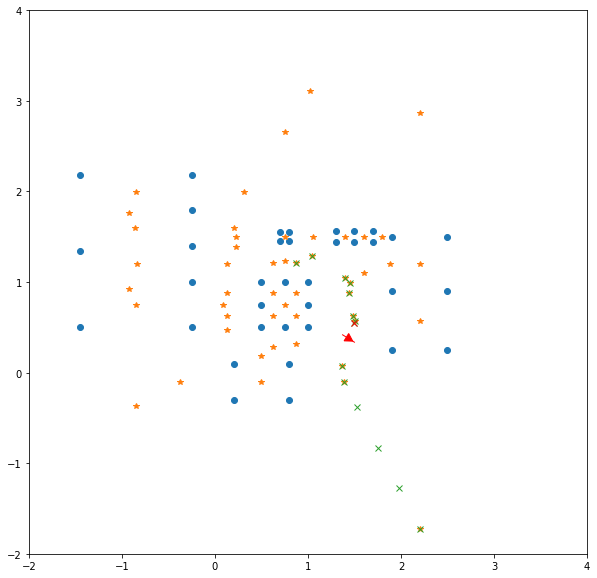

Step:  121
theta:1.2042170052087013
e:0.1589149997137582 e_theta:1.7627427489997665
(v,omega): [[0.14      ]
 [0.88137137]]
(x,y,theta) before: 1.4343286250247056, 0.38241419870695326, 5.724659563388521
Clamped wheel Velocities: [[5.93483946]
 [2.68054515]] (0.28481227473726584, 0.33875166283671376)
(x,y,theta) after: 1.4465125198913606, 0.3755275551948452, 5.8127967008385095
[[0.08075286]
 [0.87547289]]
Robot speed boosted [[0.14      ]
 [0.87547289]]
[[0.08196591]
 [0.86942722]]
Robot speed boosted [[0.14      ]
 [0.86942722]]
[[0.0830948 ]
 [0.86328345]]
Robot speed boosted [[0.14      ]
 [0.86328345]]
[[0.0841383 ]
 [0.85708535]]
Robot speed boosted [[0.14      ]
 [0.85708535]]
[[0.08509577]
 [0.85087188]]
Robot speed boosted [[0.14      ]
 [0.85087188]]
[[0.08596709]
 [0.84467775]]
Robot speed boosted [[0.14      ]
 [0.84467775]]
[[0.08675262]
 [0.83853388]]
Robot speed boosted [[0.14      ]
 [0.83853388]]
[[0.08745313]
 [0.83246781]]
Robot speed boosted [[0.14      ]
 [0.83246781

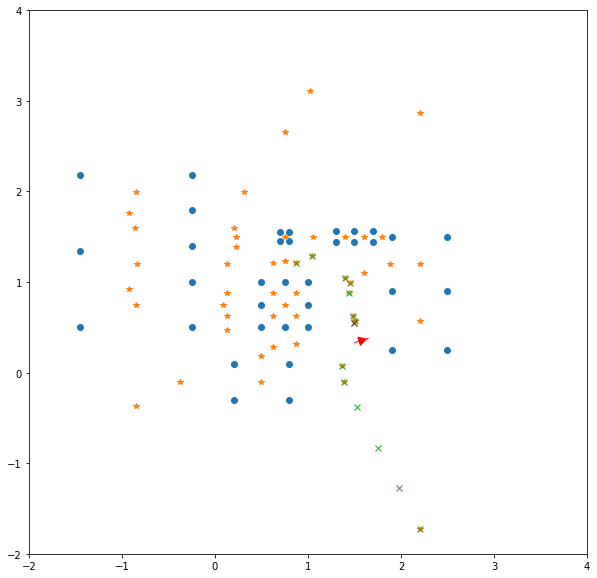

Step:  131
theta:1.9367725182059816
e:0.17720807672414882 e_theta:1.6413286996671559
(v,omega): [[0.14      ]
 [0.82066435]]
(x,y,theta) before: 1.569029159326638, 0.36529393636544444, 6.578629125718412
Clamped wheel Velocities: [[5.82276495]
 [2.79261966]] (0.28626778781617823, 0.3366684935602034)
(x,y,theta) after: 1.5822403827139628, 0.36991493170627987, 6.66069556070177
[[0.08905773]
 [0.81496819]]
Robot speed boosted [[0.14      ]
 [0.81496819]]
[[0.08943291]
 [0.8094328 ]]
Robot speed boosted [[0.14     ]
 [0.8094328]]
[[0.08973189]
 [0.80407351]]
Robot speed boosted [[0.14      ]
 [0.80407351]]
[[0.0899572 ]
 [0.79890391]]
Robot speed boosted [[0.14      ]
 [0.79890391]]
[[0.09011155]
 [0.79393602]]
Robot speed boosted [[0.14      ]
 [0.79393602]]
[[0.09019781]
 [0.78918044]]
Robot speed boosted [[0.14      ]
 [0.78918044]]
[[0.09021904]
 [0.7846465 ]]
Robot speed boosted [[0.14     ]
 [0.7846465]]
[[0.09017837]
 [0.78034232]]
Robot speed boosted [[0.14      ]
 [0.78034232]]
[[0

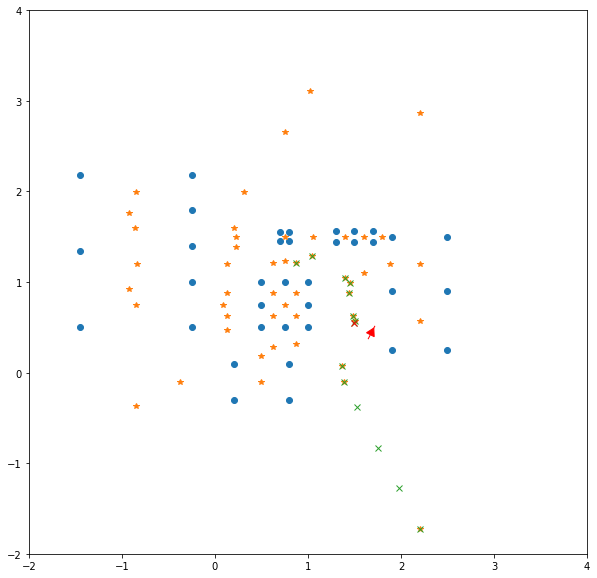

Step:  141
theta:2.6375868935297424
e:0.17984908777734263 e_theta:1.544900776024865
(v,omega): [[0.14      ]
 [0.77245039]]
(x,y,theta) before: 1.6734549436760935, 0.45292734916547267, 7.375871424684464
Clamped wheel Velocities: [[5.73375456]
 [2.88163005]] (0.28742376692078114, 0.3350140253249911)
(x,y,theta) after: 1.6794101254026603, 0.46559377614062447, 7.453116463485707
[[0.08971819]
 [0.76887374]]
Robot speed boosted [[0.14      ]
 [0.76887374]]
[[0.08946354]
 [0.76554916]]
Robot speed boosted [[0.14      ]
 [0.76554916]]
[[0.08916415]
 [0.76247996]]
Robot speed boosted [[0.14      ]
 [0.76247996]]
[[0.08882362]
 [0.75966864]]
Robot speed boosted [[0.14      ]
 [0.75966864]]
[[0.08844558]
 [0.75711686]]
Robot speed boosted [[0.14      ]
 [0.75711686]]
[[0.08803368]
 [0.75482551]]
Robot speed boosted [[0.14      ]
 [0.75482551]]
[[0.08759156]
 [0.75279466]]
Robot speed boosted [[0.14      ]
 [0.75279466]]
[[0.08712288]
 [0.75102363]]
Robot speed boosted [[0.14      ]
 [0.75102363]

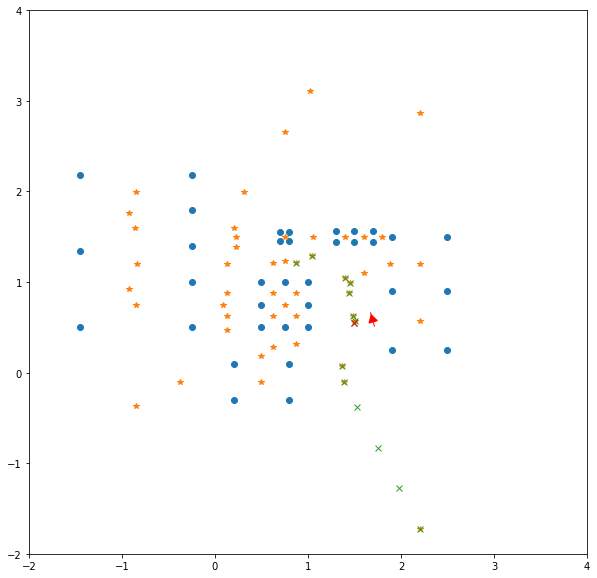

Step:  151
theta:-2.93456148507105
e:0.1722405295561433 e_theta:1.4965083593422204
(v,omega): [[0.14      ]
 [0.74825418]]
(x,y,theta) before: 1.6865914047048367, 0.588957956068835, 8.135300769945902
Clamped wheel Velocities: [[5.68908464]
 [2.92629998]] (0.28800389579210156, 0.3341837293567444)
(x,y,theta) after: 1.682205352648361, 0.6022497248243868, 8.210126187913012
[[0.08559349]
 [0.74725035]]
Robot speed boosted [[0.14      ]
 [0.74725035]]
[[0.08505444]
 [0.74649545]]
Robot speed boosted [[0.14      ]
 [0.74649545]]
[[0.08450654]
 [0.74598468]]
Robot speed boosted [[0.14      ]
 [0.74598468]]
[[0.08395317]
 [0.74571241]]
Robot speed boosted [[0.14      ]
 [0.74571241]]
[[0.08339762]
 [0.74567209]]
Robot speed boosted [[0.14      ]
 [0.74567209]]
[[0.08284306]
 [0.74585632]]
Robot speed boosted [[0.14      ]
 [0.74585632]]
[[0.08229258]
 [0.74625683]]
Robot speed boosted [[0.14      ]
 [0.74625683]]
[[0.08174914]
 [0.74686444]]
Robot speed boosted [[0.14      ]
 [0.74686444]]
[[0

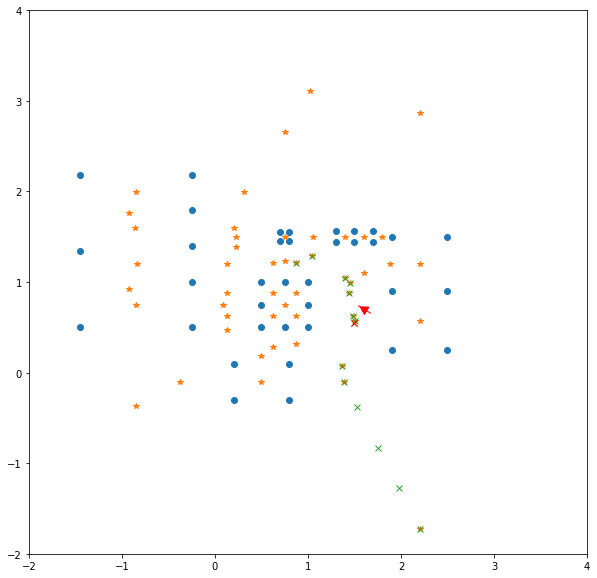

Step:  161
theta:-2.1871480836959964
e:0.1613890075003494 e_theta:1.4973201719165896
(v,omega): [[0.14      ]
 [0.74866009]]
(x,y,theta) before: 1.6033101841055115, 0.6974540045394757, 8.881902358746586
Clamped wheel Velocities: [[5.689834  ]
 [2.92555061]] (0.287994163773228, 0.33419765808264146)
(x,y,theta) after: 1.5910636010263774, 0.7042311479623085, 8.956768367342416
[[0.08018851]
 [0.74982557]]
Robot speed boosted [[0.14      ]
 [0.74982557]]
[[0.07969993]
 [0.75115315]]
Robot speed boosted [[0.14      ]
 [0.75115315]]
[[0.07923094]
 [0.75262967]]
Robot speed boosted [[0.14      ]
 [0.75262967]]
[[0.07878353]
 [0.75424132]]
Robot speed boosted [[0.14      ]
 [0.75424132]]
[[0.07835949]
 [0.75597374]]
Robot speed boosted [[0.14      ]
 [0.75597374]]
[[0.07796041]
 [0.75781206]]
Robot speed boosted [[0.14      ]
 [0.75781206]]
[[0.07758768]
 [0.75974106]]
Robot speed boosted [[0.14      ]
 [0.75974106]]
[[0.07724246]
 [0.76174524]]
Robot speed boosted [[0.14      ]
 [0.76174524]]


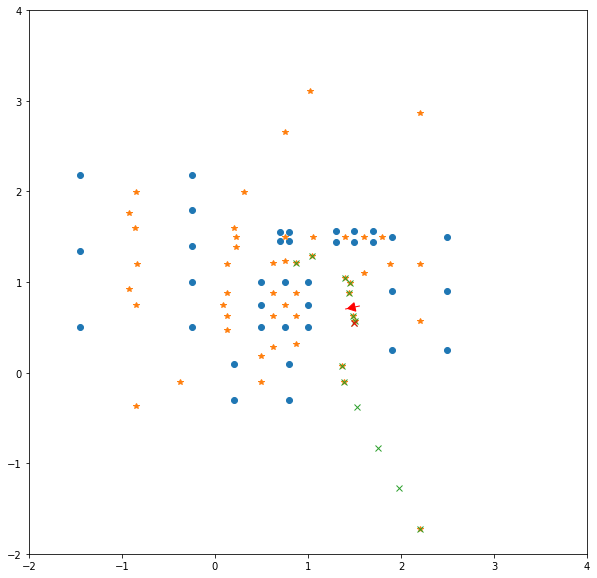

Step:  171
theta:-1.3970759307589726
e:0.15327622905943888 e_theta:1.5318332388641416
(v,omega): [[0.14      ]
 [0.76591662]]
(x,y,theta) before: 1.4685056397853276, 0.7201100473745846, 9.637461444736058
Clamped wheel Velocities: [[5.72169222]
 [2.89369239]] (0.2875804207129177, 0.3347898182247213)
(x,y,theta) after: 1.4549475789378783, 0.7166339592225687, 9.714053106679264
[[0.07638024]
 [0.76805263]]
Robot speed boosted [[0.14      ]
 [0.76805263]]
[[0.07615235]
 [0.77020171]]
Robot speed boosted [[0.14      ]
 [0.77020171]]
[[0.07595454]
 [0.77234895]]
Robot speed boosted [[0.14      ]
 [0.77234895]]
[[0.07578669]
 [0.77447994]]
Robot speed boosted [[0.14      ]
 [0.77447994]]
[[0.07564847]
 [0.77658089]]
Robot speed boosted [[0.14      ]
 [0.77658089]]
[[0.07553937]
 [0.77863876]]
Robot speed boosted [[0.14      ]
 [0.77863876]]
[[0.07545871]
 [0.78064133]]
Robot speed boosted [[0.14      ]
 [0.78064133]]
[[0.07540564]
 [0.78257731]]
Robot speed boosted [[0.14      ]
 [0.78257731]]

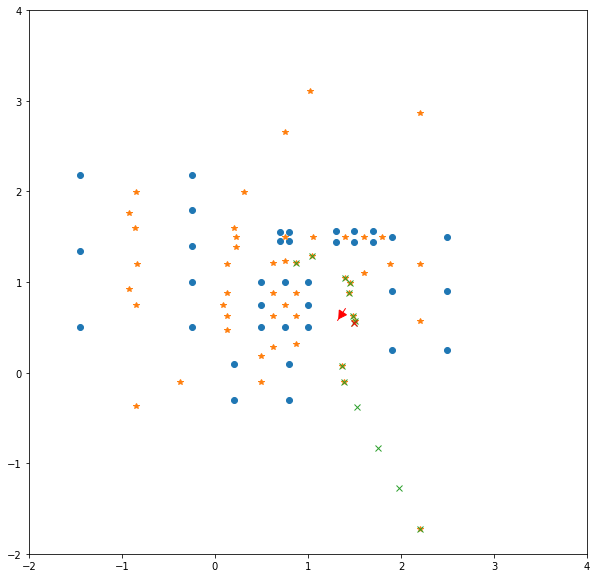

Step:  181
theta:-0.5811028112214187
e:0.15075618343177846 e_theta:1.5724189021103232
(v,omega): [[0.14      ]
 [0.78620945]]
(x,y,theta) before: 1.3557281947792186, 0.6431778164001247, 10.41284890102743
Clamped wheel Velocities: [[5.75915591]
 [2.85622871]] (0.28709387929538105, 0.33548616932416964)
(x,y,theta) after: 1.3484911911685793, 0.6311976311313755, 10.491469846132947
[[0.07540121]
 [0.78788825]]
Robot speed boosted [[0.14      ]
 [0.78788825]]
[[0.07544715]
 [0.78946583]]
Robot speed boosted [[0.14      ]
 [0.78946583]]
[[0.07551442]
 [0.79093633]]
Robot speed boosted [[0.14      ]
 [0.79093633]]
[[0.07560152]
 [0.79229503]]
Robot speed boosted [[0.14      ]
 [0.79229503]]
[[0.07570683]
 [0.79353833]]
Robot speed boosted [[0.14      ]
 [0.79353833]]
[[0.07582874]
 [0.79466371]]
Robot speed boosted [[0.14      ]
 [0.79466371]]
[[0.07596556]
 [0.7956697 ]]
Robot speed boosted [[0.14     ]
 [0.7956697]]
[[0.07611564]
 [0.79655583]]
Robot speed boosted [[0.14      ]
 [0.79655583]

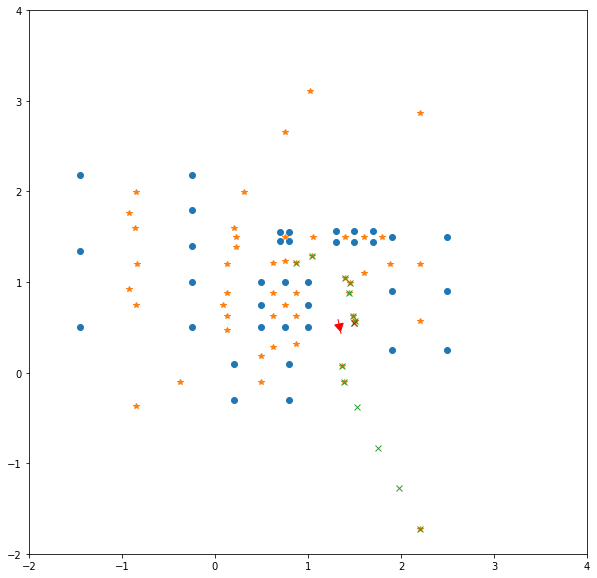

Step:  191
theta:0.23487518248947087
e:0.15289770564837743 e_theta:1.595942394496559
(v,omega): [[0.14     ]
 [0.7979712]]
(x,y,theta) before: 1.3303055563121886, 0.5092048514888748, 11.205303402352085
Clamped wheel Velocities: [[5.7808699 ]
 [2.83451471]] (0.2868118793866549, 0.33588977514149143)
(x,y,theta) after: 1.3337632434430102, 0.49564238792335336, 11.285100522076913
[[0.07662868]
 [0.79850389]]
Robot speed boosted [[0.14      ]
 [0.79850389]]
[[0.07681518]
 [0.79892349]]
Robot speed boosted [[0.14      ]
 [0.79892349]]
[[0.07700679]
 [0.7992335 ]]
Robot speed boosted [[0.14     ]
 [0.7992335]]
[[0.07720199]
 [0.799438  ]]
Robot speed boosted [[0.14    ]
 [0.799438]]
[[0.07739936]
 [0.79954156]]
Robot speed boosted [[0.14      ]
 [0.79954156]]
[[0.0775975]
 [0.7995492]]
Robot speed boosted [[0.14     ]
 [0.7995492]]
[[0.07779511]
 [0.79946627]]
Robot speed boosted [[0.14      ]
 [0.79946627]]
[[0.07799096]
 [0.79929842]]
Robot speed boosted [[0.14      ]
 [0.79929842]]
[[0.0781

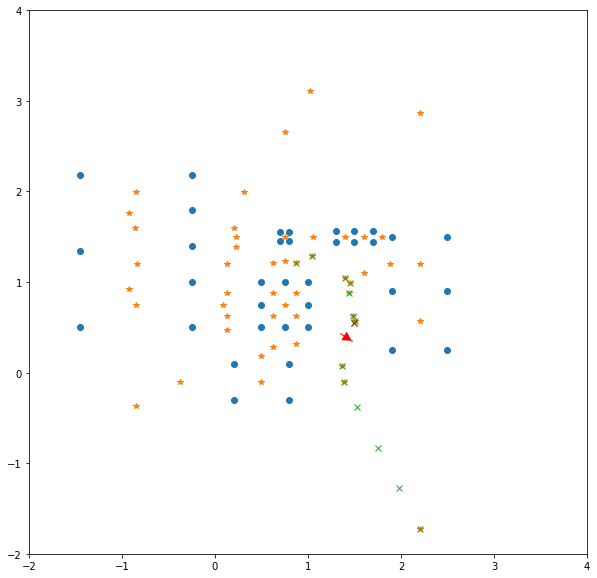

Step:  201
theta:1.035493788093508
e:0.1567457979631756 e_theta:1.5974632937888789
(v,omega): [[0.14      ]
 [0.79873165]]
(x,y,theta) before: 1.4082978203447165, 0.39742028570498716, 12.004401108663801
Clamped wheel Velocities: [[5.78227381]
 [2.83311081]] (0.28679364682770603, 0.33591587006786805)
(x,y,theta) after: 1.4204298965250126, 0.3904411347839095, 12.084274273353245
[[0.07855693]
 [0.79834491]]
Robot speed boosted [[0.14      ]
 [0.79834491]]
[[0.07873513]
 [0.79789752]]
Robot speed boosted [[0.14      ]
 [0.79789752]]
[[0.07890668]
 [0.7973957 ]]
Robot speed boosted [[0.14     ]
 [0.7973957]]
[[0.07907086]
 [0.79684562]]
Robot speed boosted [[0.14      ]
 [0.79684562]]
[[0.07922705]
 [0.79625341]]
Robot speed boosted [[0.14      ]
 [0.79625341]]
[[0.07937468]
 [0.79562505]]
Robot speed boosted [[0.14      ]
 [0.79562505]]
[[0.07951331]
 [0.79496642]]
Robot speed boosted [[0.14      ]
 [0.79496642]]
[[0.07964254]
 [0.79428323]]
Robot speed boosted [[0.14      ]
 [0.79428323]]

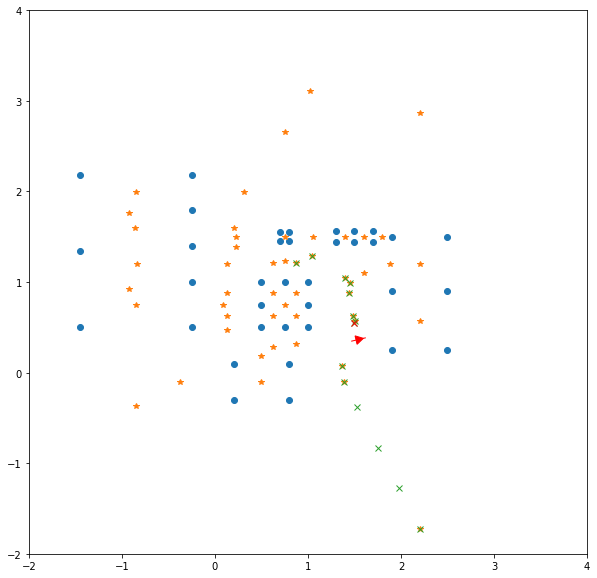

Step:  211
theta:1.8201528731470769
e:0.15974333570150023 e_theta:1.5857299315155977
(v,omega): [[0.14      ]
 [0.79286497]]
(x,y,theta) before: 1.5428132209141843, 0.3752577531411019, 12.800793555990651
Clamped wheel Velocities: [[5.77144301]
 [2.8439416 ]] (0.28693430651529783, 0.33571455415811774)
(x,y,theta) after: 1.556287187932146, 0.37904583409136894, 12.88008005256643
[[0.07997118]
 [0.79214029]]
Robot speed boosted [[0.14      ]
 [0.79214029]]
[[0.08006051]
 [0.79141179]]
Robot speed boosted [[0.14      ]
 [0.79141179]]
[[0.08013964]
 [0.79068404]]
Robot speed boosted [[0.14      ]
 [0.79068404]]
[[0.08020862]
 [0.78996138]]
Robot speed boosted [[0.14      ]
 [0.78996138]]
[[0.08026754]
 [0.78924787]]
Robot speed boosted [[0.14      ]
 [0.78924787]]
[[0.08031655]
 [0.78854728]]
Robot speed boosted [[0.14      ]
 [0.78854728]]
[[0.08035587]
 [0.78786311]]
Robot speed boosted [[0.14      ]
 [0.78786311]]
[[0.08038574]
 [0.78719859]]
Robot speed boosted [[0.14      ]
 [0.78719859

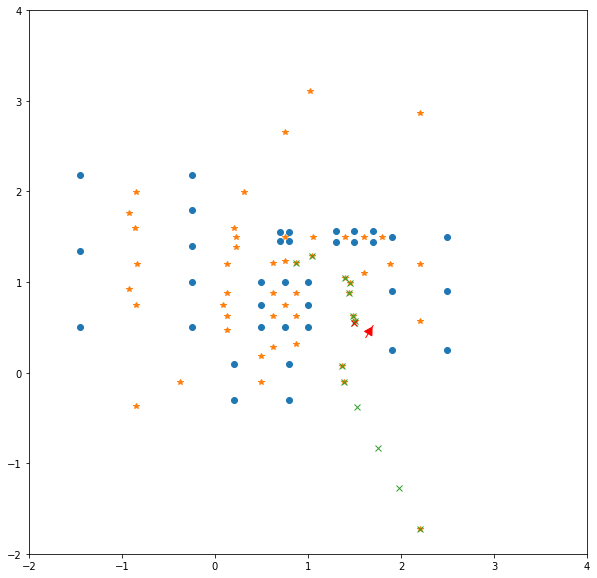

Step:  221
theta:2.595950429302977
e:0.16083674596625414 e_theta:1.5718798912277396
(v,omega): [[0.14      ]
 [0.78593995]]
(x,y,theta) before: 1.653034275089173, 0.4555935478879873, 13.59044115243441
Clamped wheel Velocities: [[5.75865836]
 [2.85672625]] (0.28710034096430315, 0.33547692121065664)
(x,y,theta) after: 1.6598355670718237, 0.46782635447016563, 13.669035146995798
[[0.08042184]
 [0.78535085]]
Robot speed boosted [[0.14      ]
 [0.78535085]]
[[0.08041726]
 [0.78479147]]
Robot speed boosted [[0.14      ]
 [0.78479147]]
[[0.08040506]
 [0.7842636 ]]
Robot speed boosted [[0.14     ]
 [0.7842636]]
[[0.0803857 ]
 [0.78376882]]
Robot speed boosted [[0.14      ]
 [0.78376882]]
[[0.08035966]
 [0.7833084 ]]
Robot speed boosted [[0.14     ]
 [0.7833084]]
[[0.08032741]
 [0.78288336]]
Robot speed boosted [[0.14      ]
 [0.78288336]]
[[0.08028946]
 [0.7824945 ]]
Robot speed boosted [[0.14     ]
 [0.7824945]]
[[0.08024632]
 [0.78214234]]
Robot speed boosted [[0.14      ]
 [0.78214234]]
[[0.

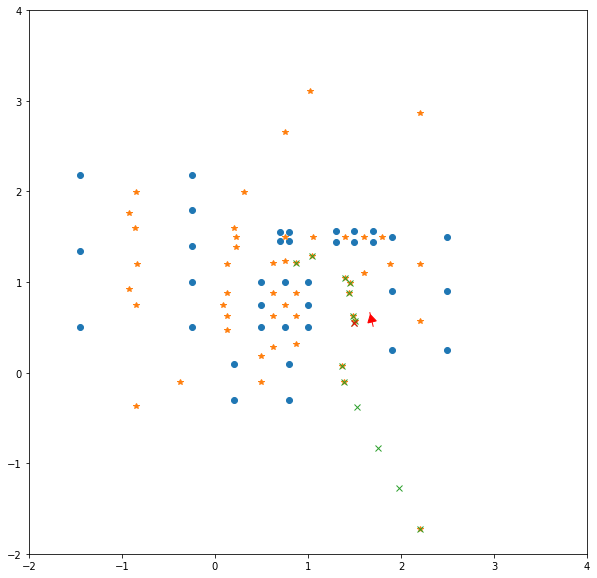

Step:  231
theta:-2.9123395366614626
e:0.1602930946589732 e_theta:1.5630981857016017
(v,omega): [[0.14      ]
 [0.78154909]]
(x,y,theta) before: 1.6740320557555444, 0.5904135315895721, 14.374118199175694
Clamped wheel Velocities: [[5.75055217]
 [2.86483244]] (0.28720561615542567, 0.33532624853934745)
(x,y,theta) after: 1.6702175108311512, 0.603880138446163, 14.452273108460775
[[0.08009095]
 [0.78130794]]
Robot speed boosted [[0.14      ]
 [0.78130794]]
[[0.08003222]
 [0.78110337]]
Robot speed boosted [[0.14      ]
 [0.78110337]]
[[0.07997088]
 [0.78093484]]
Robot speed boosted [[0.14      ]
 [0.78093484]]
[[0.07990743]
 [0.78080163]]
Robot speed boosted [[0.14      ]
 [0.78080163]]
[[0.07984236]
 [0.78070284]]
Robot speed boosted [[0.14      ]
 [0.78070284]]
[[0.07977613]
 [0.78063741]]
Robot speed boosted [[0.14      ]
 [0.78063741]]
[[0.07970922]
 [0.78060414]]
Robot speed boosted [[0.14      ]
 [0.78060414]]
[[0.07964205]
 [0.78060169]]
Robot speed boosted [[0.14      ]
 [0.78060169

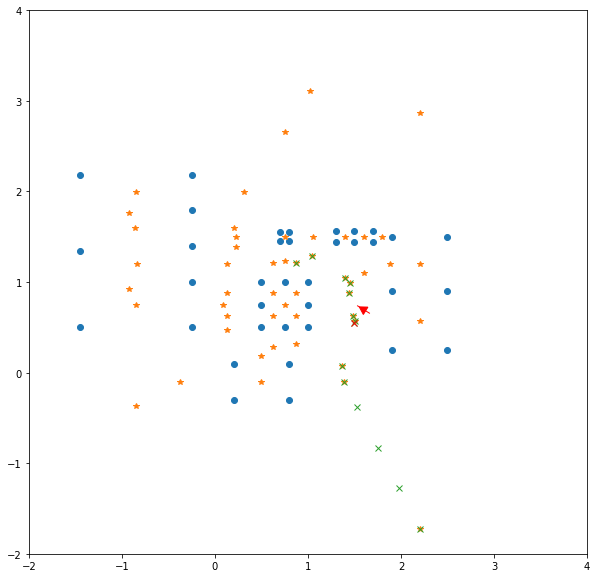

Step:  241
theta:-2.1331839394161625
e:0.1590172652017443 e_theta:1.5613666268968274
(v,omega): [[0.14      ]
 [0.78068331]]
(x,y,theta) before: 1.5939094443799433, 0.7008877007737796, 15.155005355225768
Clamped wheel Velocities: [[5.74895381]
 [2.86643081]] (0.28722637410313523, 0.33529653920898245)
(x,y,theta) after: 1.5817210277663774, 0.7077683238916935, 15.23307368657061
[[0.07944316]
 [0.78076416]]
Robot speed boosted [[0.14      ]
 [0.78076416]]
[[0.07937899]
 [0.7808694 ]]
Robot speed boosted [[0.14     ]
 [0.7808694]]
[[0.07931645]
 [0.78099723]]
Robot speed boosted [[0.14      ]
 [0.78099723]]
[[0.07925584]
 [0.78114579]]
Robot speed boosted [[0.14      ]
 [0.78114579]]
[[0.07919745]
 [0.78131317]]
Robot speed boosted [[0.14      ]
 [0.78131317]]
[[0.07914153]
 [0.78149745]]
Robot speed boosted [[0.14      ]
 [0.78149745]]
[[0.07908828]
 [0.78169668]]
Robot speed boosted [[0.14      ]
 [0.78169668]]
[[0.07903792]
 [0.78190892]]
Robot speed boosted [[0.14      ]
 [0.78190892]]

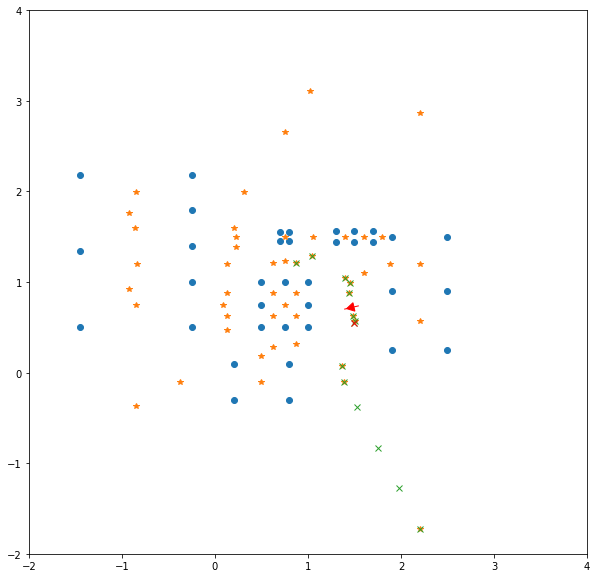

Step:  251
theta:-1.3485203262430117
e:0.15789298640282592 e_theta:1.5647294046109685
(v,omega): [[0.14     ]
 [0.7823647]]
(x,y,theta) before: 1.4592395339701818, 0.7229583859522726, 15.936306190684778
Clamped wheel Velocities: [[5.75205791]
 [2.8633267 ]] (0.2871860610835851, 0.3353542362815728)
(x,y,theta) after: 1.445740747607315, 0.7192593574735872, 16.01454266091533
[[0.07890568]
 [0.78260445]]
Robot speed boosted [[0.14      ]
 [0.78260445]]
[[0.07886827]
 [0.78284964]]
Robot speed boosted [[0.14      ]
 [0.78284964]]
[[0.07883431]
 [0.78309849]]
Robot speed boosted [[0.14      ]
 [0.78309849]]
[[0.07880386]
 [0.78334926]]
Robot speed boosted [[0.14      ]
 [0.78334926]]
[[0.07877692]
 [0.78360032]]
Robot speed boosted [[0.14      ]
 [0.78360032]]
[[0.07875348]
 [0.78385008]]
Robot speed boosted [[0.14      ]
 [0.78385008]]
[[0.07873353]
 [0.78409705]]
Robot speed boosted [[0.14      ]
 [0.78409705]]
[[0.078717  ]
 [0.78433983]]
Robot speed boosted [[0.14      ]
 [0.78433983]]
[

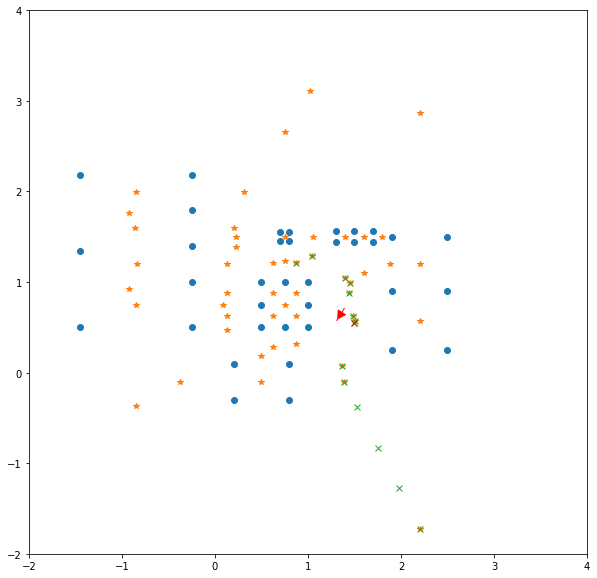

Step:  261
theta:-0.5601612953375857
e:0.15738790694282728 e_theta:1.569615341935858
(v,omega): [[0.14      ]
 [0.78480767]]
(x,y,theta) before: 1.3481784676159299, 0.6436921297941898, 16.719779284265314
Clamped wheel Velocities: [[5.75656801]
 [2.85881661]] (0.28712748840836166, 0.33543806706209706)
(x,y,theta) after: 1.341227089955585, 0.6315439707359087, 16.798260051362107
[[0.07868724]
 [0.78503042]]
Robot speed boosted [[0.14      ]
 [0.78503042]]
[[0.07868359]
 [0.78524434]]
Robot speed boosted [[0.14      ]
 [0.78524434]]
[[0.07868286]
 [0.78544854]]
Robot speed boosted [[0.14      ]
 [0.78544854]]
[[0.07868493]
 [0.78564223]]
Robot speed boosted [[0.14      ]
 [0.78564223]]
[[0.07868962]
 [0.78582472]]
Robot speed boosted [[0.14      ]
 [0.78582472]]
[[0.07869679]
 [0.78599542]]
Robot speed boosted [[0.14      ]
 [0.78599542]]
[[0.07870627]
 [0.78615386]]
Robot speed boosted [[0.14      ]
 [0.78615386]]
[[0.07871788]
 [0.78629967]]
Robot speed boosted [[0.14      ]
 [0.78629967

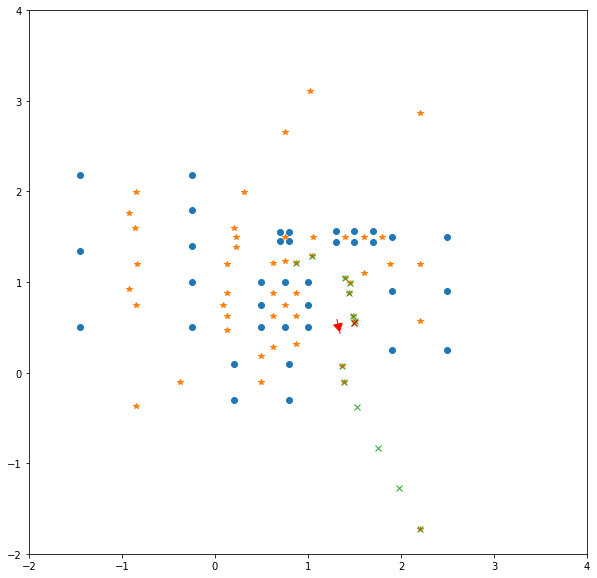

Step:  271
theta:0.22901604601825945
e:0.15749352604911004 e_theta:1.5731047398885387
(v,omega): [[0.14      ]
 [0.78655237]]
(x,y,theta) before: 1.325596865014971, 0.5091474131098626, 17.50546722766848
Clamped wheel Velocities: [[5.75978899]
 [2.85559562]] (0.28708565746387393, 0.33549793662948646)
(x,y,theta) after: 1.3292766316589015, 0.495643402974871, 17.584122464662904
[[0.07876368]
 [0.78665899]]
Robot speed boosted [[0.14      ]
 [0.78665899]]
[[0.07878199]
 [0.78675243]]
Robot speed boosted [[0.14      ]
 [0.78675243]]
[[0.07880152]
 [0.78683277]]
Robot speed boosted [[0.14      ]
 [0.78683277]]
[[0.07882209]
 [0.78690017]]
Robot speed boosted [[0.14      ]
 [0.78690017]]
[[0.07884351]
 [0.78695487]]
Robot speed boosted [[0.14      ]
 [0.78695487]]
[[0.07886561]
 [0.78699716]]
Robot speed boosted [[0.14      ]
 [0.78699716]]
[[0.07888822]
 [0.78702742]]
Robot speed boosted [[0.14      ]
 [0.78702742]]
[[0.07891118]
 [0.78704605]]
Robot speed boosted [[0.14      ]
 [0.78704605]

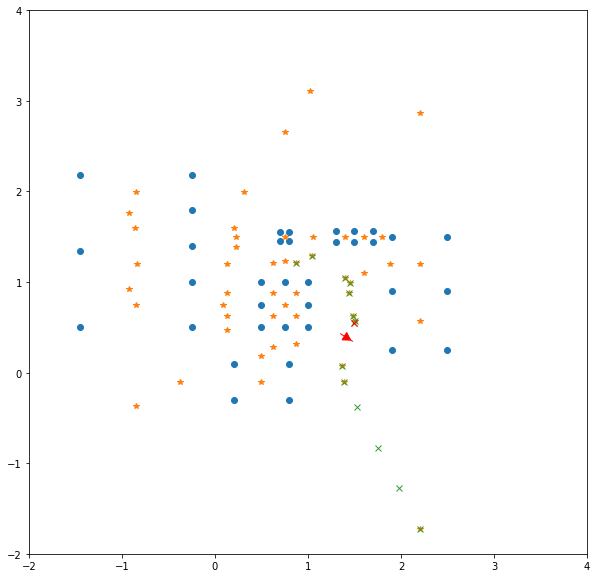

Step:  281
theta:1.0168897256782743
e:0.15791495254107202 e_theta:1.5741008412004085
(v,omega): [[0.14      ]
 [0.78705042]]
(x,y,theta) before: 1.4048703748360845, 0.3981294682172045, 18.292344806016626
Clamped wheel Velocities: [[5.76070847]
 [2.85467615]] (0.287073716189406, 0.3355150273011228)
(x,y,theta) after: 1.417031572375219, 0.39120096774907726, 18.371049848076645
[[0.07898053]
 [0.78703722]]
Robot speed boosted [[0.14      ]
 [0.78703722]]
[[0.07900333]
 [0.78701455]]
Robot speed boosted [[0.14      ]
 [0.78701455]]
[[0.07902575]
 [0.78698303]]
Robot speed boosted [[0.14      ]
 [0.78698303]]
[[0.07904767]
 [0.78694329]]
Robot speed boosted [[0.14      ]
 [0.78694329]]
[[0.07906898]
 [0.78689601]]
Robot speed boosted [[0.14      ]
 [0.78689601]]
[[0.07908958]
 [0.78684185]]
Robot speed boosted [[0.14      ]
 [0.78684185]]
[[0.07910938]
 [0.78678151]]
Robot speed boosted [[0.14      ]
 [0.78678151]]
[[0.0791283 ]
 [0.78671566]]
Robot speed boosted [[0.14      ]
 [0.78671566]]

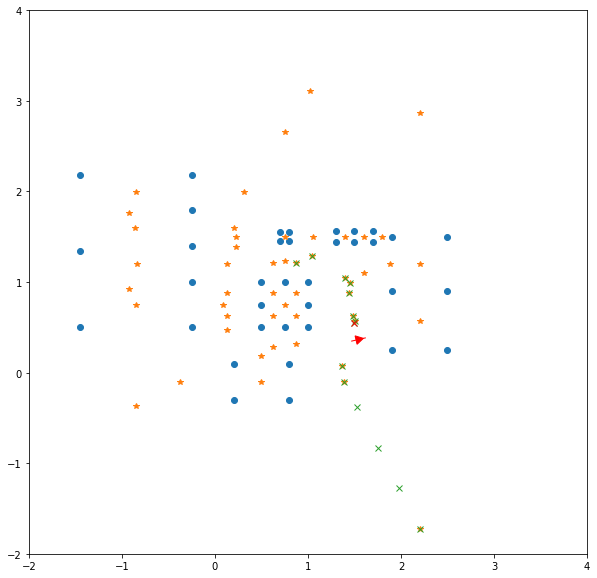

Step:  291
theta:1.8028200949201243
e:0.1583263933518439 e_theta:1.5731403569594242
(v,omega): [[0.14      ]
 [0.78657018]]
(x,y,theta) before: 1.5394617919817166, 0.37589409570054316, 19.07923565949946
Clamped wheel Velocities: [[5.75982187]
 [2.85556275]] (0.2870852304860012, 0.3354985477316464)
(x,y,theta) after: 1.5529548023668514, 0.3796139933405987, 19.15789267734743
[[0.07917907]
 [0.7864919 ]]
Robot speed boosted [[0.14     ]
 [0.7864919]]
[[0.07919382]
 [0.78641081]]
Robot speed boosted [[0.14      ]
 [0.78641081]]
[[0.07920742]
 [0.78632755]]
Robot speed boosted [[0.14      ]
 [0.78632755]]
[[0.07921984]
 [0.78624274]]
Robot speed boosted [[0.14      ]
 [0.78624274]]
[[0.07923107]
 [0.78615698]]
Robot speed boosted [[0.14      ]
 [0.78615698]]
[[0.0792411 ]
 [0.78607085]]
Robot speed boosted [[0.14      ]
 [0.78607085]]
[[0.07924992]
 [0.78598489]]
Robot speed boosted [[0.14      ]
 [0.78598489]]
[[0.07925754]
 [0.78589963]]
Robot speed boosted [[0.14      ]
 [0.78589963]]
[[

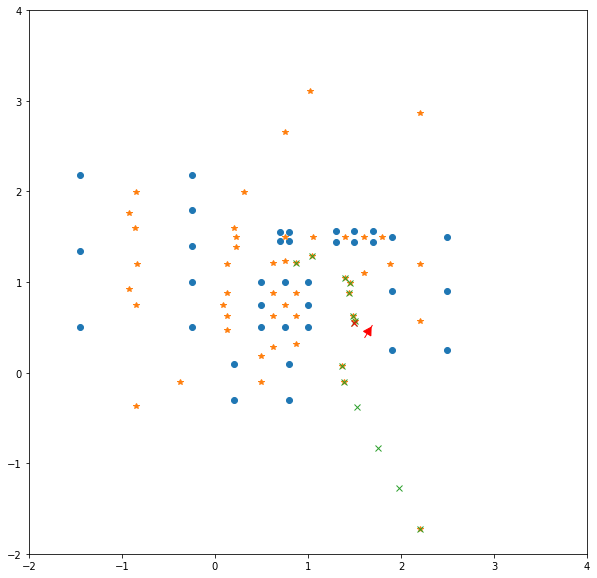

Step:  301
theta:2.587343057241022
e:0.15853848707516782 e_theta:1.5714662121067597
(v,omega): [[0.14      ]
 [0.78573311]]
(x,y,theta) before: 1.6502665719954388, 0.4554761147333415, 19.86543276667302
Clamped wheel Velocities: [[5.7582765 ]
 [2.85710811]] (0.2871053001545646, 0.3354698234848177)
(x,y,theta) after: 1.6571679932763286, 0.4676527138845479, 19.94400607727836


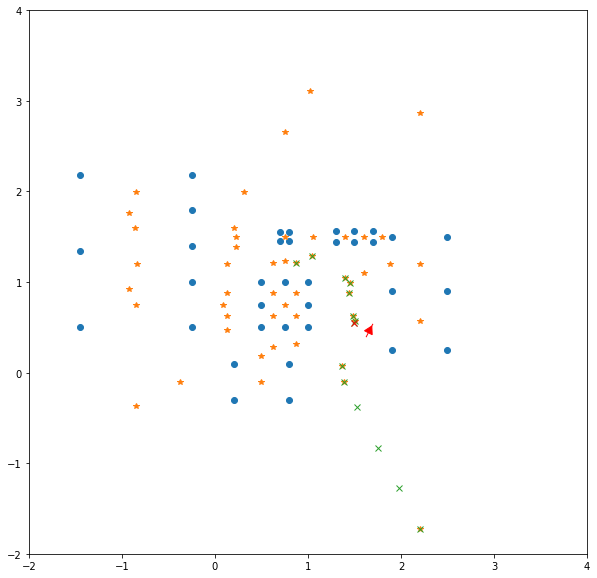

End of Trajectory!!!


In [549]:
def last_pt(trajec_params):
    """ Return true if current pt is the last pt of the trajectory """
    if trajec_params["current"] == len(trajec_params["points"]):
        # Return None if already at the last pt of trajectory
        return True
    else:
        return False
    

def next_pursuit_pt(robot_pose, pursuit_pt, trajec_params):
    """ Provide next pursuit point to robot if available or if necessary """
    
    if last_pt(trajec_params):
        # Return None if already at the last pt of trajectory
        return None
    else:
        # Look for suitable next pursuit pt in trajectory
        while distance(robot_pos,pursuit_pt)<0.10:
            trajec_params["current"] += 1  # set next pt in trajectory as pursuit pt
            if last_pt(trajec_params):
                # Return None if reaches the last pt of trajectory
                return None
            pursuit_pt = trajec_params["points"][trajec_params["current"]]
            
    return pursuit_pt

def clamp(wheel_velocities, upper_limit, lower_limit, T, debug=False):
    """ Put limits on motor speed """
    
    robot_velocities = np.dot(T, wheel_velocities)  # get (tranl_vel, ang_vel)
    print(robot_velocities)
    tranl_velocity = robot_velocities[0,0]
    
    # Set lower limit on translational speed to 0.15m/s (motor setting 0.3)
    if abs(tranl_velocity) < lower_limit:
        robot_velocities[0,0] = tranl_velocity/abs(tranl_velocity) * lower_limit
        if debug:
            print("Robot speed boosted", robot_velocities) 
    # Set upper limit on translational speed to 0.49m/s (motor setting 0.5)
    elif abs(tranl_velocity) > upper_limit:
        robot_velocities[0,0] = tranl_velocity/abs(tranl_velocity) * upper_limit
        if debug:
            print("Robot speed limited", robot_velocities)
            
    ang_velocity = robot_velocities[1,0]
    ang_upper_limit = 5.0
    if abs(ang_velocity) > ang_upper_limit:
        robot_velocities[1,0] = ang_velocity/abs(ang_velocity) * ang_upper_limit
        if debug:
            print("Rotational speed limited", robot_velocities)
            
    # return clamped wheel velocities
    return np.dot(np.linalg.pinv(T), robot_velocities)

def omega2speed(in_val, mapping):
    """ Map wheel angular speed to motor speed setting based on a calibration mapping """
    
    if in_val < 0:
        sign = -1
        in_val = abs(in_val)
    else:
        sign = 1
        
    out_lower = 0
    in_lower = 0
    out_val = 0

    for i, in_upper in enumerate(mapping["omega"]):
        # print (i, in_upper)
        if in_val < in_upper:
            out_upper = mapping["speed"][i]
            out_val = out_lower + (in_val - in_lower)/(in_upper - in_lower) \
                *(out_upper-out_lower)
            # print("yes", out_val)
            break
        else:
            # print("no")
            out_lower = mapping["speed"][i]
            in_lower = in_upper
            
    if out_val is 0:
        print ("Input is too high!!!", in_val)
        out_val = 0
        
    return sign*out_val

# load control parameters 
num_iter = control_params["num_iter"]
interval = control_params["interval"]
motion = control_params["motion"]
debug = control_params["debug"]
speed_lower_limit = control_params["speed_lower"]
speed_upper_limit = control_params["speed_upper"]

# load robot parameters
wheel_radius = robot_params["wheel_radius"]
axle_length = robot_params["axle_length"]
dt = robot_params["motor_on_time"]
robot_pose = [robot_params["start_x"],robot_params["start_y"],robot_params["start_theta"]]
T = control2robot(wheel_radius, axle_length)

# load trajectory parameters
trajec_params["points"] = generate_trajectory(shortest, vor, 0.5, debug=True)
trajec_params["current"] = 0  # current points to trajectory's first pt

# Map parameters
display_param = {
    "figsize": (10,10),
    "xlim": [-2,4],
    "ylim": [-2,4]
    }

# the point in the trajectory closed to the robot is the pursuit point, update current
trajec_params["current"], pursuit_pt = closest_point(trajec_params,robot_pose)
pursuit_x = pursuit_pt[0]
pursuit_y = pursuit_pt[1]

K_v = pursuit_params['K_v']
K_i = pursuit_params['K_i']
K_h = pursuit_params['K_h']
lag = pursuit_params['lag']

robot_x = robot_pose[0]
robot_y = robot_pose[1]
robot_theta = robot_pose[2]
sum_errors = 0

""" Robot pursuit a moving point """
for i in range(num_iter):
    
    robot_pos = [robot_x ,robot_y]
    
    """ =================== """        
    """ Pursuit Following   """
    """ =================== """
    pursuit_pt = next_pursuit_pt(robot_pose, pursuit_pt, trajec_params)
    if pursuit_pt is None:
        break
    pursuit_x = pursuit_pt[0]
    pursuit_y = pursuit_pt[1]

    # PI Controller for v
    error_pos = distance(robot_pos,pursuit_pt)-lag
    v = K_v*error_pos + K_i*sum_errors  # P-componet
    sum_errors += error_pos  # I-Component

    # P Controller for omega
    theta = math.atan2((pursuit_y-robot_y),(pursuit_x-robot_x))
    error_theta =  normalize_angle(theta-robot_theta)  # critical to normalize angle!!!
    omega = K_h*error_theta
    
    robot_velocities = np.array([[v],[omega]])
    
    """ Clamp motor setting to (0.3-0.5) """
    inv_T = np.linalg.pinv(T)
    unclamped_velocities = np.dot(inv_T, robot_velocities)
    wheel_velocities = clamp(unclamped_velocities, speed_upper_limit, \
                                 speed_lower_limit, T, debug=True) 
    robot_velocities = np.dot(T, wheel_velocities)
    v = robot_velocities[0,0]
    omega = robot_velocities[1,0]
    
    """ Move robot """
    # Map wheel angular velocities to motor setting, then run motors 
    w_r = omega2speed(wheel_velocities[0,0],wheel_calibration) 
    w_l = omega2speed(wheel_velocities[1,0],wheel_calibration)
        
    if motion is True:
        robot.set_motors(w_l, w_r)  # left, right
        time.sleep(Rtime)
        robot.stop()
        
    # robot_velocities = (v,omega)
    d_x,d_y,d_theta = robot_pose_delta(v,omega,robot_theta,dt)

    if i%interval==0:
        animate_robot(robot_pose, points, vor, display_param, path=trajec_params["points"], pursuit_pt=pursuit_pt)
        print("Step: ", i+1)
        print("theta:{}".format(theta))
        print("e:{} e_theta:{}".format(error_pos, error_theta))
        print("(v,omega): {}".format(robot_velocities))
        print("(x,y,theta) before: {}, {}, {}".format(robot_x,robot_y,robot_theta))
        print("Clamped wheel Velocities:", wheel_velocities, (w_l, w_r))
    
    robot_x += d_x
    robot_y += d_y
    robot_theta += d_theta
    robot_pose = [robot_x,robot_y,robot_theta]
    
    if i%interval==0:
        print("(x,y,theta) after: {}, {}, {}".format(robot_x,robot_y,robot_theta))

animate_robot(robot_pose, points, vor, display_param, path=trajec_params["points"], pursuit_pt=pursuit_pt)
print("End of Trajectory!!!")

In [529]:
unclamped_velocities.shape

(2, 1)

In [441]:
trajec_params["current"]

86